Step 1 - Import python libraries

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


Step 2 - Load and read the data file
1.   Upload data file from Google drive and run the notebook in the cloud
2.   Upload data file from local computer and run the notebook in the cloud
3.   Load data file from local computer and run the notebook locally

Step 2 - Option 1 - Upload data file from Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Edit the `dataPath` variable to the path to your data in Google Drive.
dataPath = "/content/drive/MyDrive/complete_COVID_samples.tsv"

df_samples = pd.read_table(dataPath, sep='\t', low_memory=False, engine="c")
display(df_samples.head())


,sample,frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,age,gender,smoker,icu_admit,birth_year,blood_type,cmv_at_donation,days_from_last_symptom_to_sample,ethnicity,height_meters,hospitalized,weight_kg,race
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,72,Male,False,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,72,Male,False,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,72,Male,False,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,72,Male,False,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,72,Male,False,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian


Step 2 - Option 2 - Upload data file from local computer

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import io

# Change `fileName` to the name of the file that you uploaded into Google Drive.
filename = "complete_COVID_samples.csv"

df_samples = pd.read_table(io.BytesIO(
    uploaded[filename]), sep='\t', low_memory=False, engine="c")

display(df_samples.head())


Step 2 - Option 3 - Run the notebook locally (refer here for how to connect to local runtime https://research.google.com/colaboratory/local-runtimes.html)

In [ ]:
# Edit the `dataPath` variable to set the path to your local data.
dataPath = "../../../../Documents/complete_COVID_samples.tsv"

df_samples = pd.read_table(dataPath, sep='\t', low_memory=False, engine="c")

display(df_samples.head())


Step 3 - Create the standardized format (column content and column names)
1.   Sample name (sample)
2.   Clone frequency (freq)
3.   Clone reads count (#count)
4.   CDR3 amino acid clonotype (cdr3aa)
5.   CDR3 nucleotide (cdr3nt)
6.   V gene (v)
7.   D gene (d)
8.   J gene (j)
9.   Optional - Sample feature (here we use hospitalization as the clinical feature)

In [5]:
# select the columns that are listed above
df_samples = df_samples[['sample', 'frequency', 'templates', 'amino_acid',
                         'rearrangement', 'v_resolved', 'd_resolved', 'j_resolved', 'hospitalized']]

# rename the columns
df_samples.columns = ['sample', 'freq', '#count',
                      'cdr3aa', 'cdr3nt', 'v', 'd', 'j', 'hospitalization']
display(df_samples.head())


,sample,freq,#count,cdr3aa,cdr3nt,v,d,j,hospitalization
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True


Prepare two dataframes for merging and analyzing the overlapping

In [6]:
# if there are more than one V or J gene, leave only the first one
df_samples['v'].str.replace("(,).*", "", regex=True)
df_samples['j'].str.replace("(,).*", "", regex=True)

df_compare = pd.merge(df_samples, df_samples, on=[
                      'cdr3nt', 'cdr3aa', 'v', 'd', 'j'], suffixes=['_1', '_2'])

df_compare['#count_1**2'] = df_compare['#count_1'] * df_compare['#count_1']
df_compare['#count_2**2'] = df_compare['#count_2'] * df_compare['#count_2']
df_compare['#count_1*2'] = df_compare['#count_1'] * df_compare['#count_2']

# Prepare data for future analysis
sample_names = df_samples["sample"].drop_duplicates()
sample_names_size = sample_names.size
sample_names.index = np.arange(0, sample_names_size)

samples = {}

for sample in sample_names:
    filtered_samples = df_samples.loc[(df_samples['sample'] == sample)]
    samples[sample] = filtered_samples


Required: Prepare quick access to overlap metrics, allowing individual overlap analysis to run much quicker.

In [7]:
# Compute and store pairwise sample overlaps for quick lookup
df_overlaps = {}

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    df_compare1 = (df_compare['sample_1'] == sample1)

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_compare2 = (df_compare['sample_2'] == sample2)

        df_rows = df_compare.loc[df_compare1 & df_compare2]
        df_overlaps[f'{sample1}:{sample2}'] = df_rows


Overlap analysis 1.1 - Jaccard index (result table)

In [8]:
# create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'jaccard_index']
df_jaccard_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        jaccard_overlap = df_overlaps[f'{sample1}:{sample2}'].shape[0]

        # Calculate Jaccard Index
        jaccard = jaccard_overlap / \
            (df_sample1.shape[0] + df_sample2.shape[0] - jaccard_overlap)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jaccard_index': jaccard})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jaccard_index': jaccard})

    df_data = pd.DataFrame(data)
    df_jaccard_index = pd.concat([df_jaccard_index, df_data], copy=False, ignore_index=True)

df_jaccard_index


,sample_1,sample_2,jaccard_index
0,6232BW_TCRB,5115BW_TCRB,0.000473
1,5115BW_TCRB,6232BW_TCRB,0.000473
2,6232BW_TCRB,989003BW_TCRB,0.000636
3,989003BW_TCRB,6232BW_TCRB,0.000636
4,6232BW_TCRB,7972BW_TCRB,0.000500
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.001046
2158,1566449BW_TCRB,1566265BW_TCRB,0.001195
2159,1566265BW_TCRB,1566449BW_TCRB,0.001195
2160,3602BW_TCRB,1566265BW_TCRB,0.001129


Overlap analysis 1.2 - Jaccard index (heatmap)

Text(0.5, 1.0, 'jaccard_index')

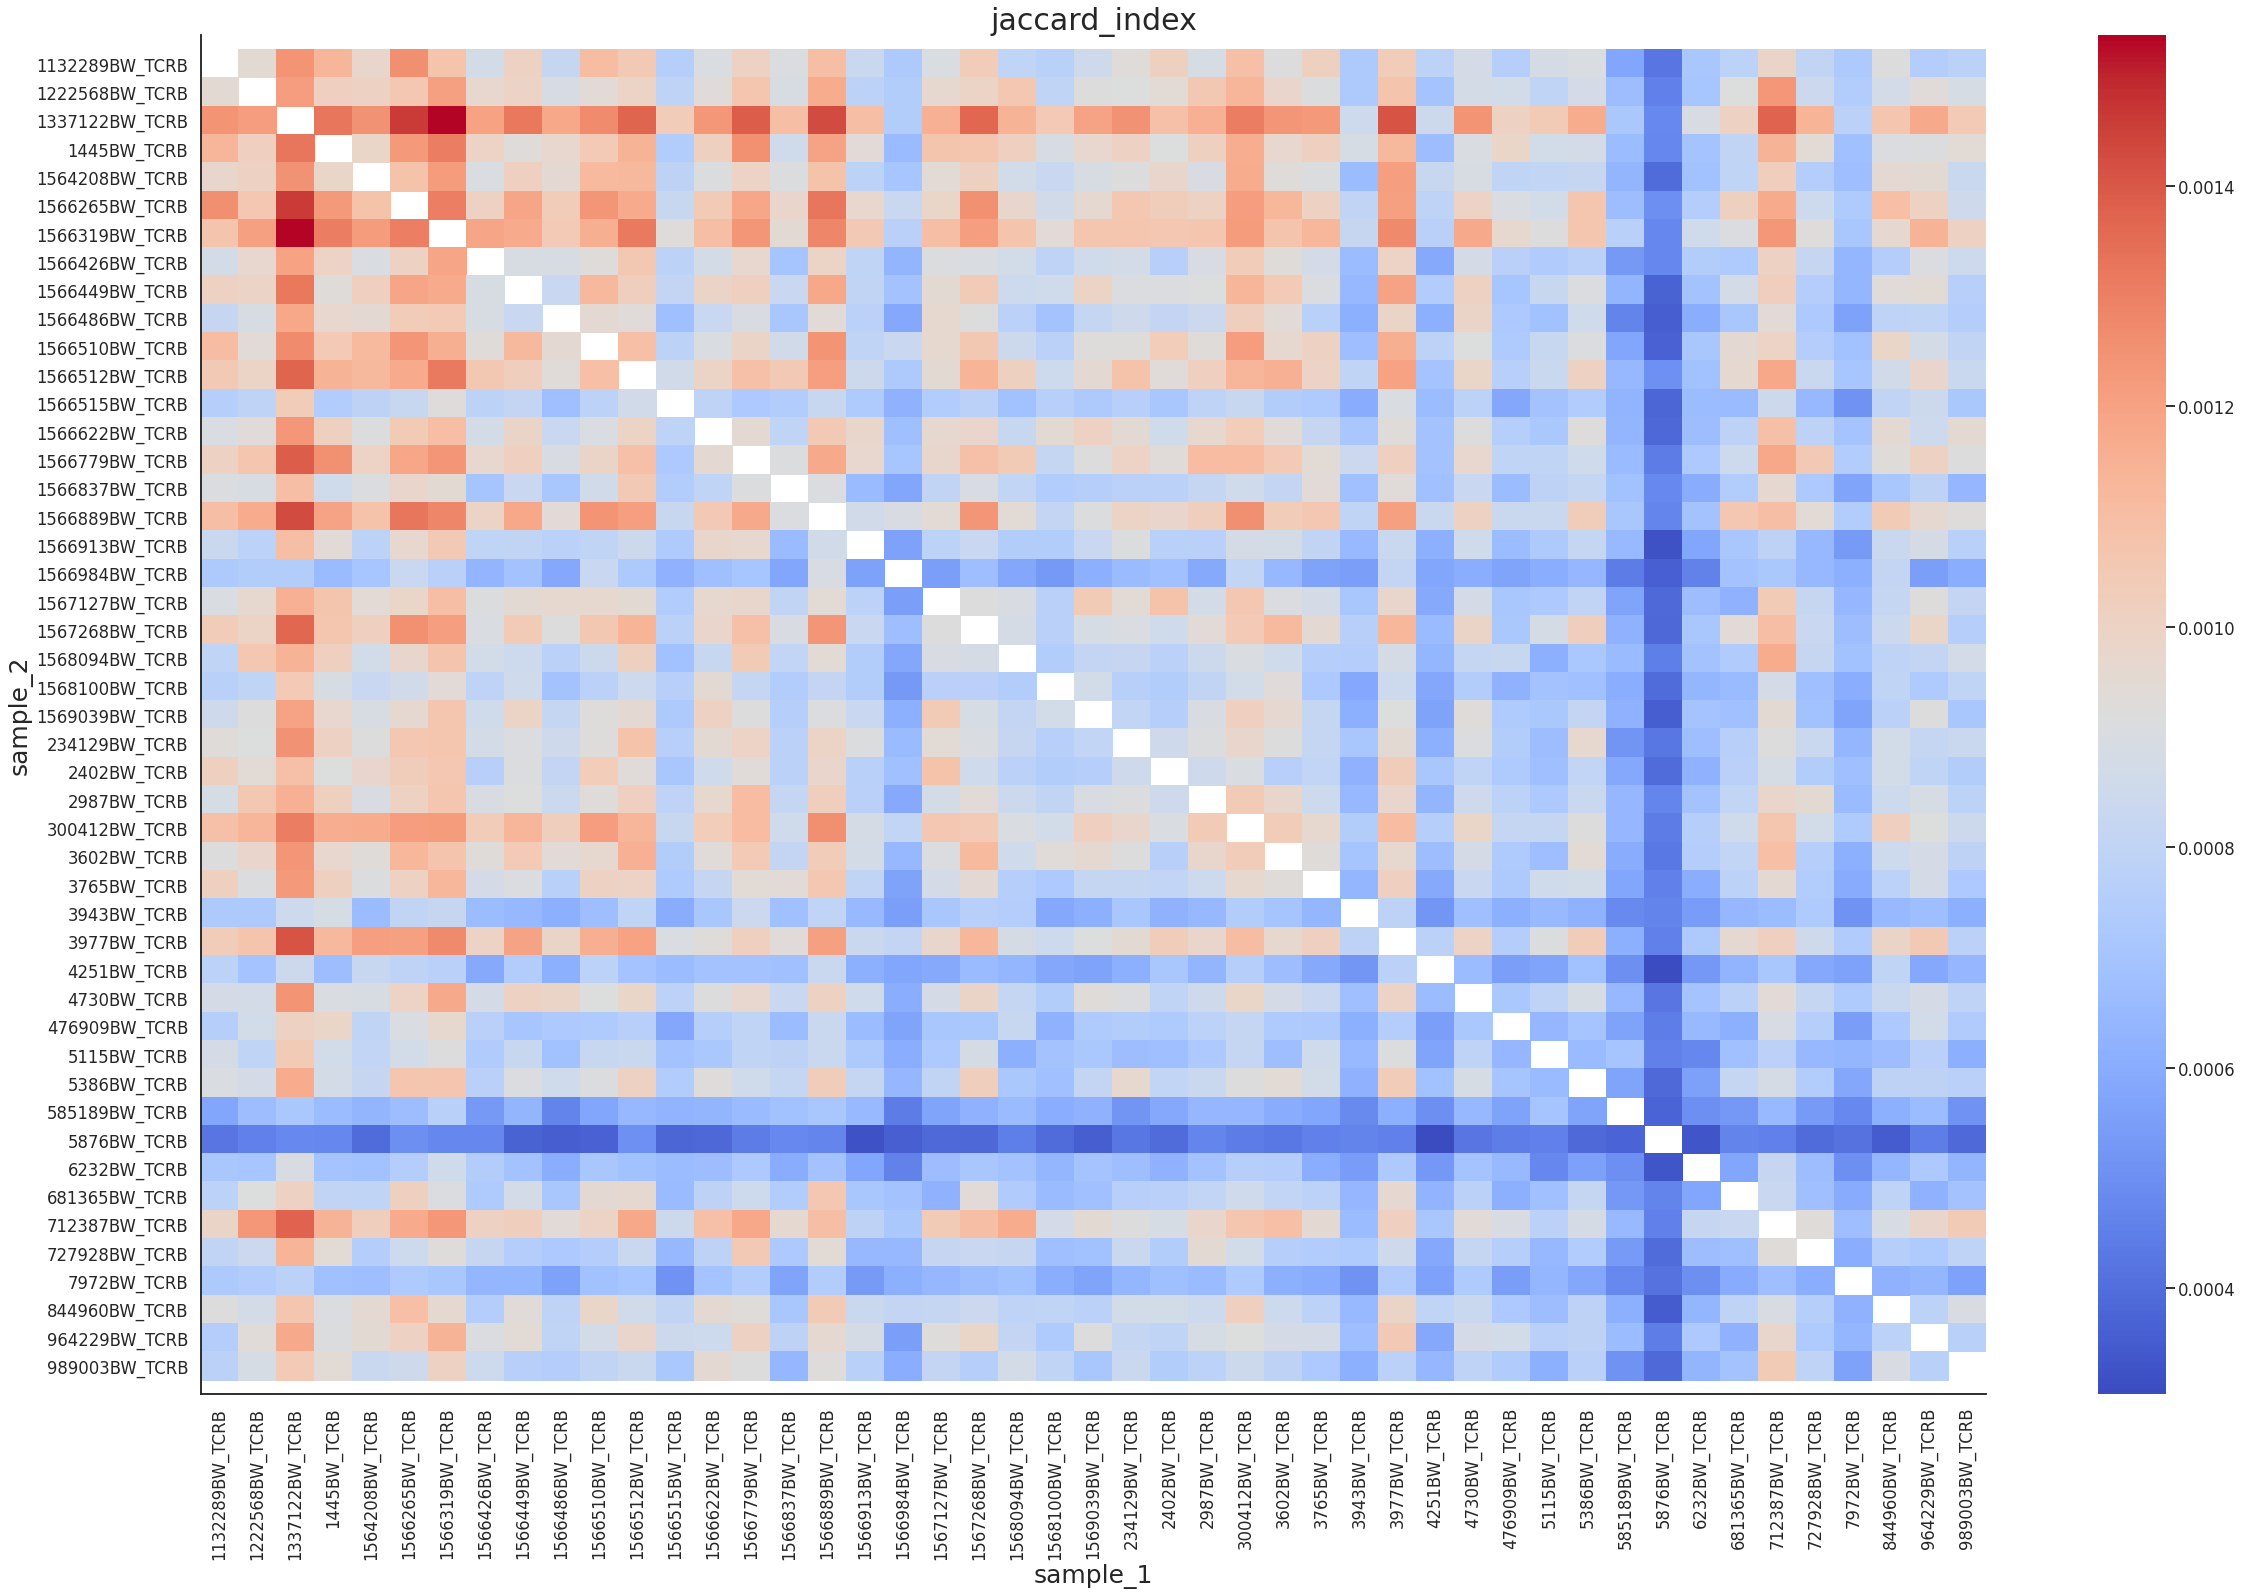

In [9]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_jaccard_index['jaccard_index'] = df_jaccard_index['jaccard_index'].astype(
    float)

result = df_jaccard_index.pivot(
    index='sample_2', columns='sample_1', values='jaccard_index')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=25)
ax.set_ylabel('sample_2', fontsize=25)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('jaccard_index', fontsize=30)


Overlap analysis 2.1 - Overlap coefficient (result table)

In [10]:
# create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'overlap_coefficient']
df_overlap_coefficient = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample2]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        sample_overlap = df_overlaps[f'{sample1}:{sample2}']

        # Calculate Overlap Coefficient
        overlap_coefficient = sample_overlap.shape[0] / \
            min(df_sample1.shape[0], df_sample2.shape[0])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'overlap_coefficient': overlap_coefficient})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'overlap_coefficient': overlap_coefficient})

    df_data = pd.DataFrame(data)
    df_overlap_coefficient = pd.concat([df_overlap_coefficient, df_data], copy=False, ignore_index=True)

display(df_overlap_coefficient)


,sample_1,sample_2,overlap_coefficient
0,6232BW_TCRB,5115BW_TCRB,0.000945
1,5115BW_TCRB,6232BW_TCRB,0.000945
2,6232BW_TCRB,989003BW_TCRB,0.001058
3,989003BW_TCRB,6232BW_TCRB,0.001058
4,6232BW_TCRB,7972BW_TCRB,0.001130
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.002049
2158,1566449BW_TCRB,1566265BW_TCRB,0.002156
2159,1566265BW_TCRB,1566449BW_TCRB,0.002156
2160,3602BW_TCRB,1566265BW_TCRB,0.002075


Overlap analysis 2.2 - Overlap coefficient (heatmap)

Text(0.5, 1.0, 'Overlap_coefficient')

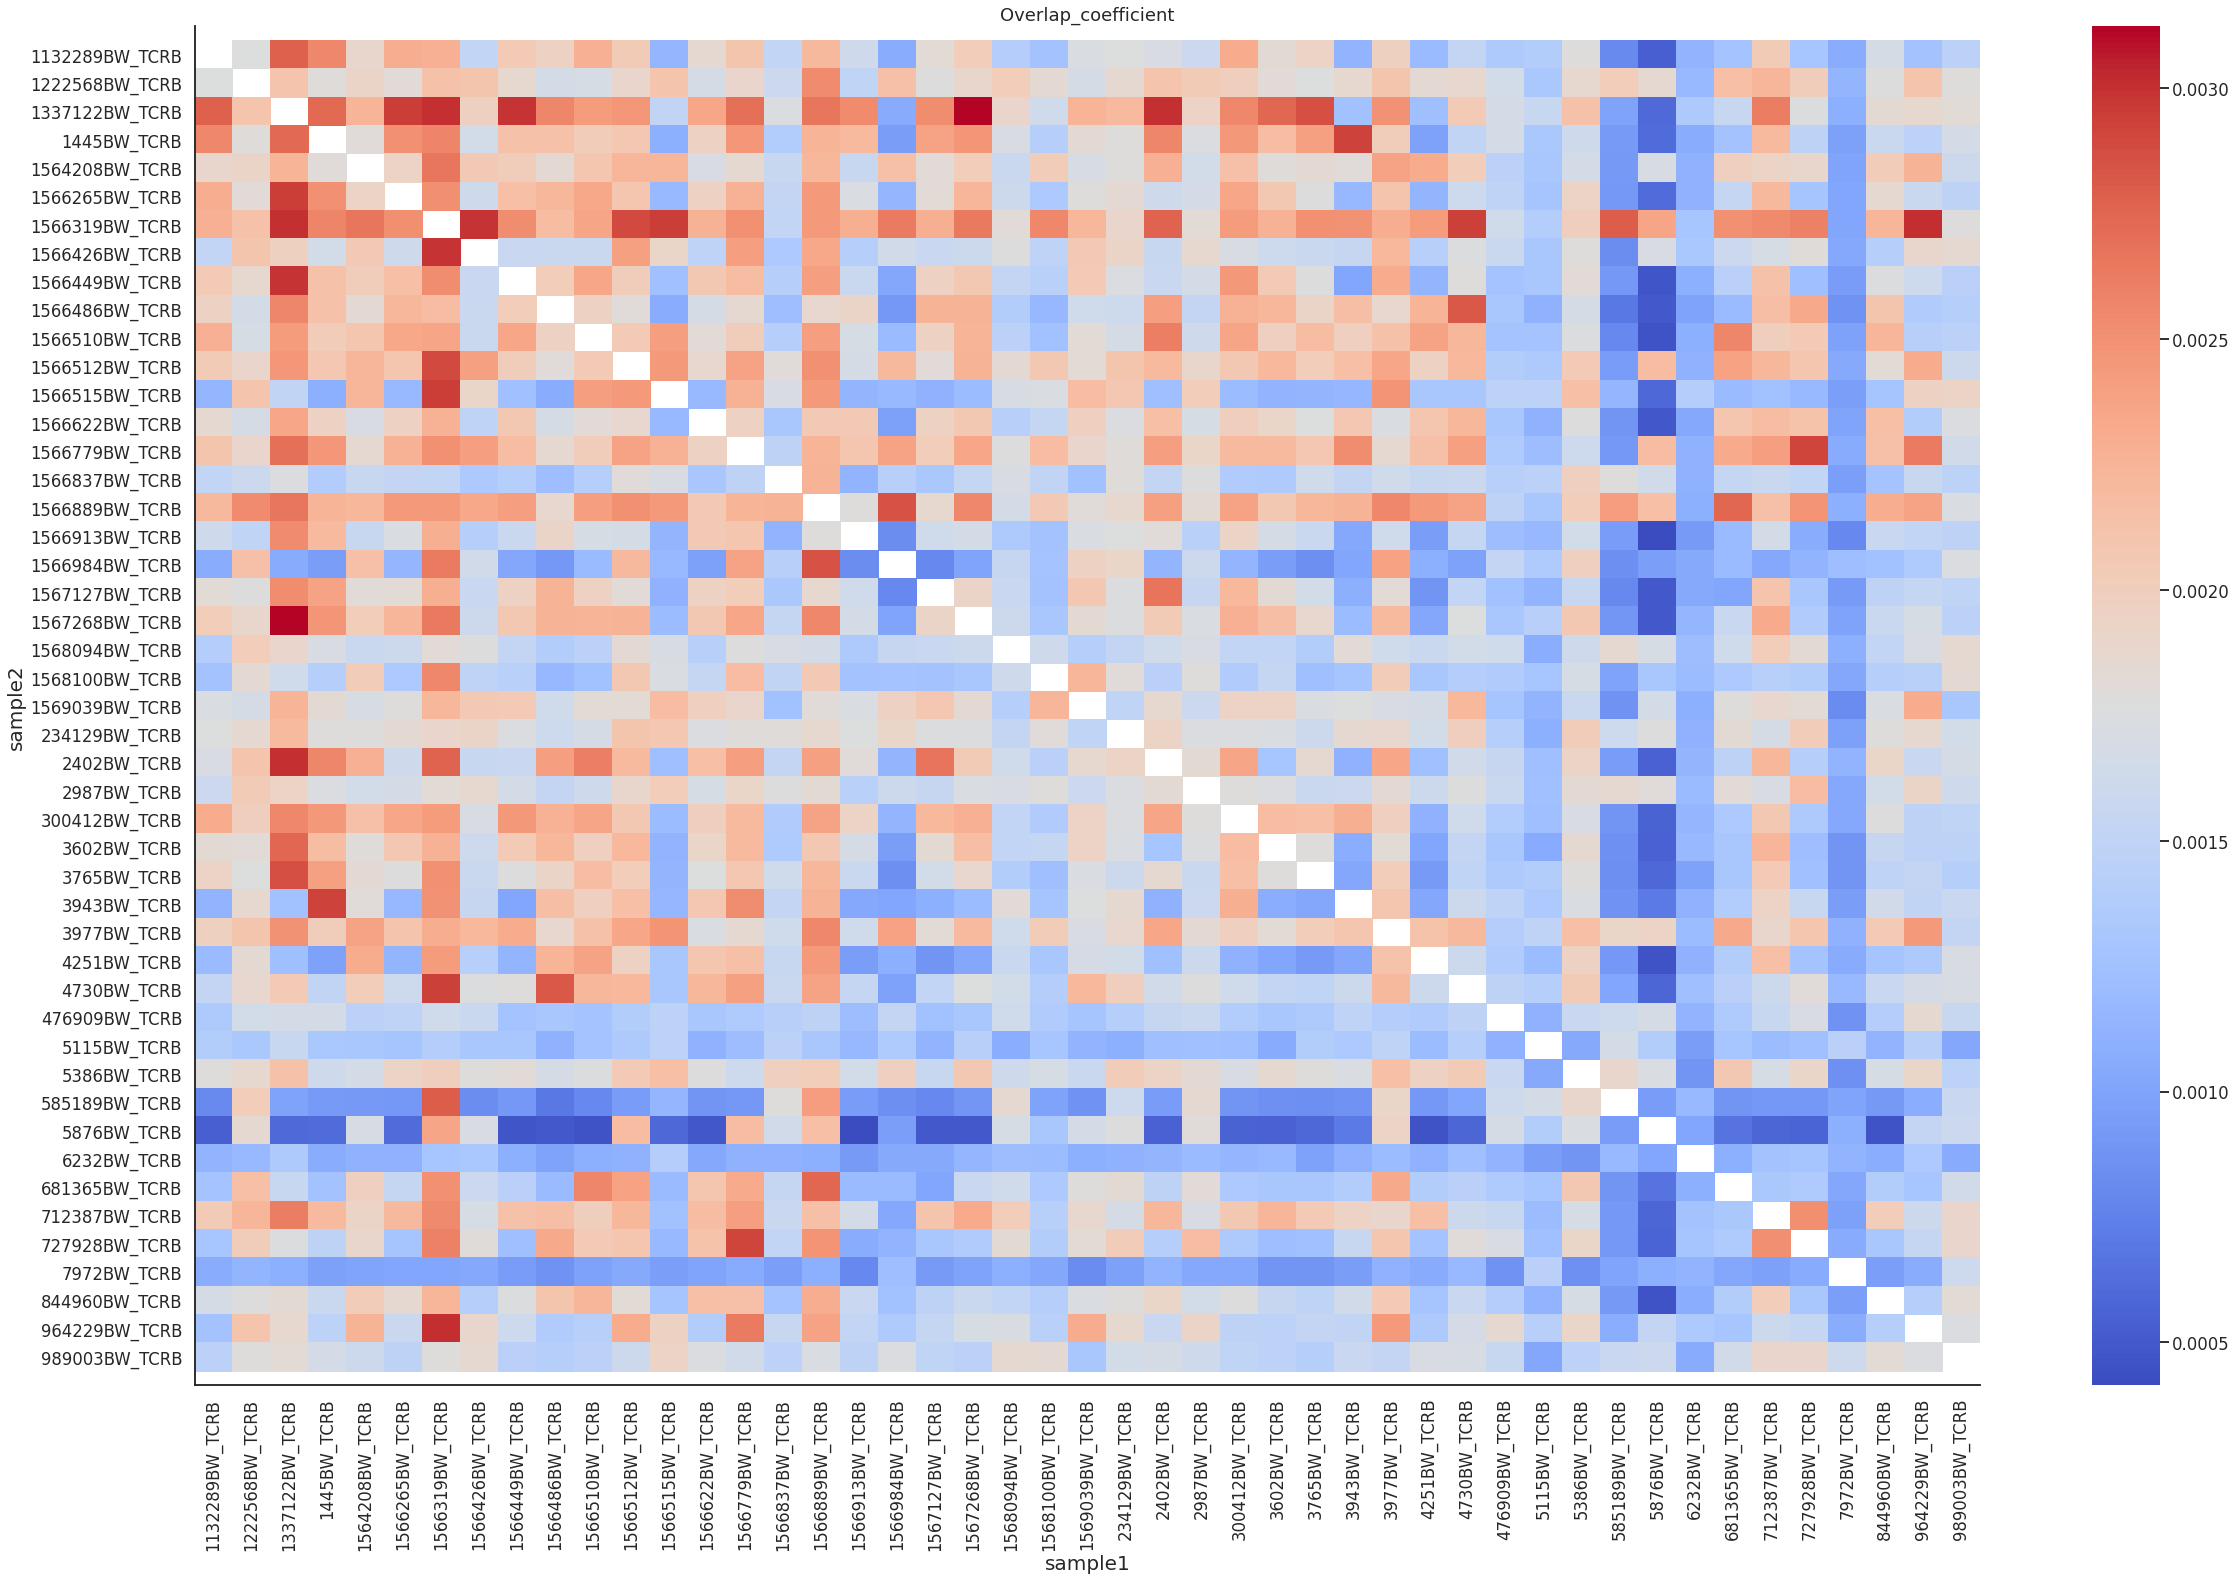

In [11]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_overlap_coefficient['overlap_coefficient'] = df_overlap_coefficient['overlap_coefficient'].astype(
    float)

result = df_overlap_coefficient.pivot(
    index='sample_2', columns='sample_1', values='overlap_coefficient')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample1', fontsize=20)
ax.set_ylabel('sample2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Overlap_coefficient')


Overlap analysis 3.1 - Morisita-Horn index (result table)

In [12]:
# create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'morisita_horn_index']
df_morisita_horm_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        sum_sample_1_count = df_sample1["#count"].sum()
        sum_sample_2_count = df_sample2["#count"].sum()

        sample_overlap = df_overlaps[f'{sample1}:{sample2}']

        sum_sample_1 = sample_overlap["#count_1**2"].sum()
        sum_sample_2 = sample_overlap["#count_2**2"].sum()

        sum_count_product = sample_overlap["#count_1*2"].sum()

        # #calculate Morisita-Horn index
        step1 = (sum_sample_1 / ((sum_sample_1_count)**2)) + \
            (sum_sample_2 / ((sum_sample_2_count)**2))
        step2 = step1 * sum_sample_1_count * sum_sample_2_count
        step3 = 2 * sum_count_product
        morisita_horn_index = step3 / step2

        # #store the results
        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'morisita_horn_index': morisita_horn_index})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'morisita_horn_index': morisita_horn_index})

    df_data = pd.DataFrame(data)
    df_morisita_horm_index = pd.concat(
        [df_morisita_horm_index, df_data], copy=False, ignore_index=True)

display(df_morisita_horm_index)


,sample_1,sample_2,morisita_horn_index
0,6232BW_TCRB,5115BW_TCRB,0.185901
1,5115BW_TCRB,6232BW_TCRB,0.185901
2,6232BW_TCRB,989003BW_TCRB,0.194270
3,989003BW_TCRB,6232BW_TCRB,0.194270
4,6232BW_TCRB,7972BW_TCRB,0.150494
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.025197
2158,1566449BW_TCRB,1566265BW_TCRB,0.129856
2159,1566265BW_TCRB,1566449BW_TCRB,0.129856
2160,3602BW_TCRB,1566265BW_TCRB,0.141251


Overlap analysis 3.2 - Morisita-Horn index (heatmap)

Text(0.5, 1.0, 'morisita_horn_index')

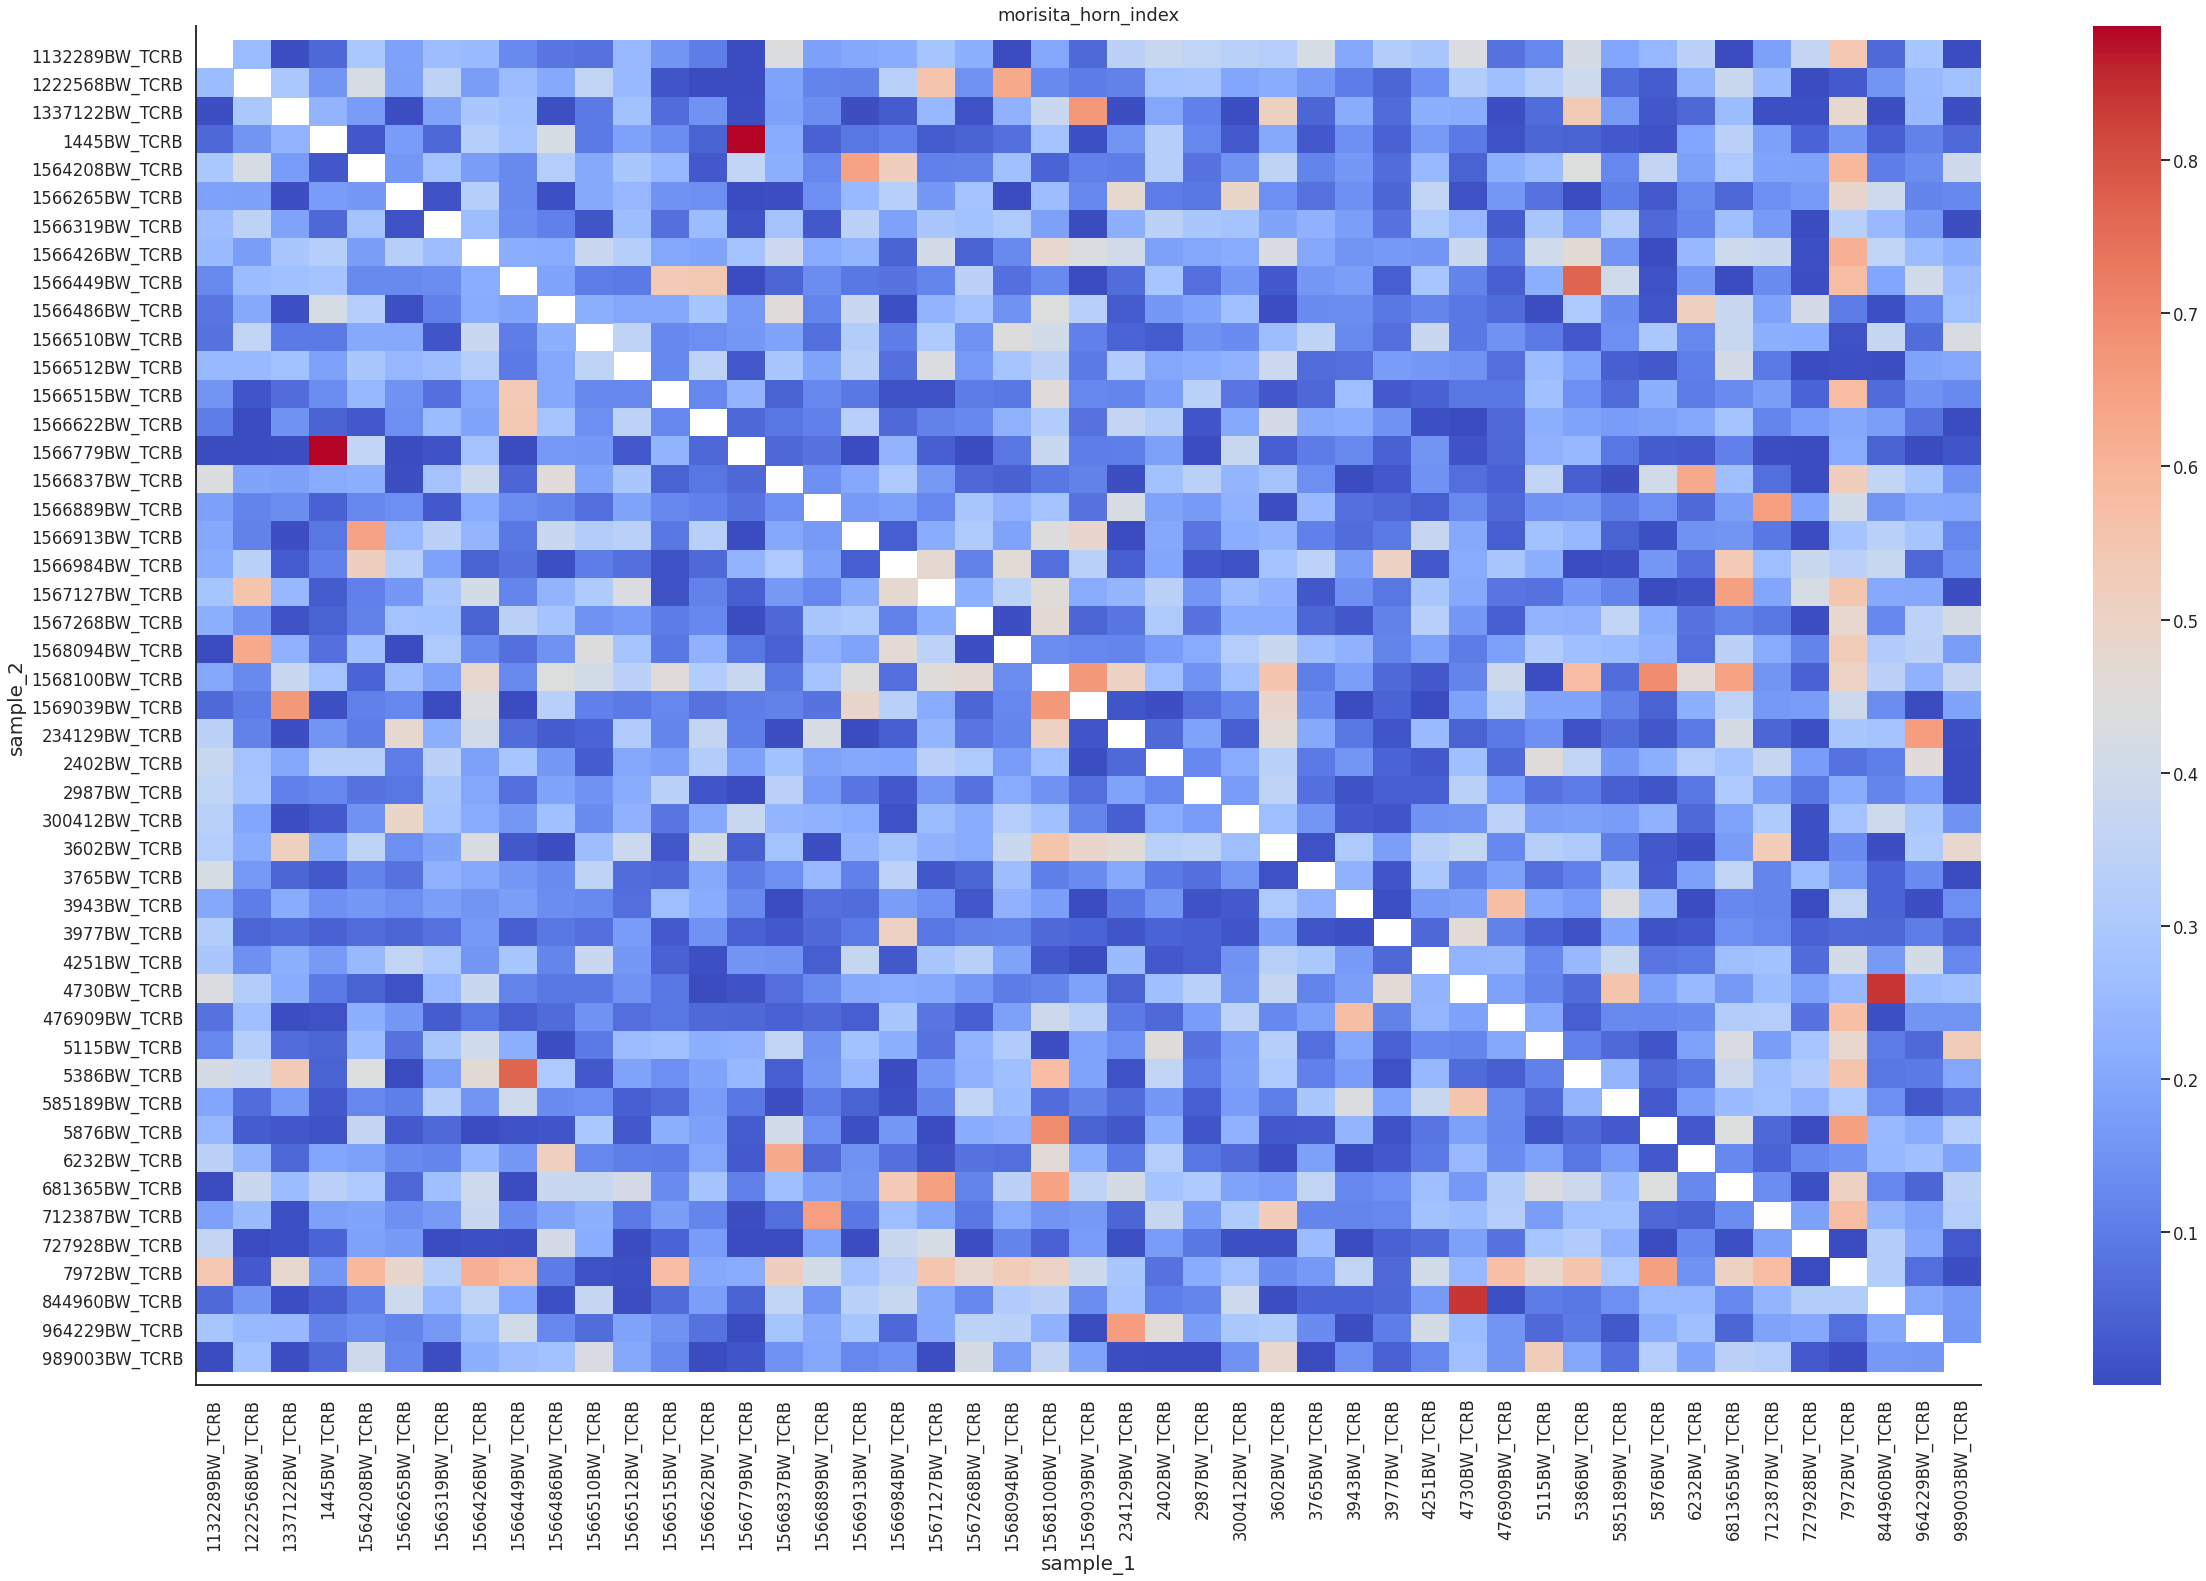

In [13]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_morisita_horm_index['morisita_horn_index'] = df_morisita_horm_index['morisita_horn_index'].astype(
    float)

result = df_morisita_horm_index.pivot(
    index='sample_2', columns='sample_1', values='morisita_horn_index')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('morisita_horn_index')


Overlap analysis 4.1 - Tversky index (result table)


In [14]:
columns = ['sample_1', 'sample_2', 'tversky_index']
df_tversky_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        tversky_index = df_overlap.shape[0] / (df_overlap.shape[0] + 0.5 * (
            df_sample1.shape[0] - df_overlap.shape[0]) + 0.5 * (df_sample2.shape[0] - df_overlap.shape[0]))

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'tversky_index': tversky_index})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'tversky_index': tversky_index})

    df_data = pd.DataFrame(data)
    df_tversky_index = pd.concat([df_tversky_index, df_data], copy=False, ignore_index=True)

display(df_tversky_index)


,sample_1,sample_2,tversky_index
0,6232BW_TCRB,5115BW_TCRB,0.000945
1,5115BW_TCRB,6232BW_TCRB,0.000945
2,6232BW_TCRB,989003BW_TCRB,0.001270
3,989003BW_TCRB,6232BW_TCRB,0.001270
4,6232BW_TCRB,7972BW_TCRB,0.000999
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.002090
2158,1566449BW_TCRB,1566265BW_TCRB,0.002386
2159,1566265BW_TCRB,1566449BW_TCRB,0.002386
2160,3602BW_TCRB,1566265BW_TCRB,0.002255


Overlap analysis 4.2 - Tversky index (heatmap)

Text(0.5, 1.0, 'tversky_index')

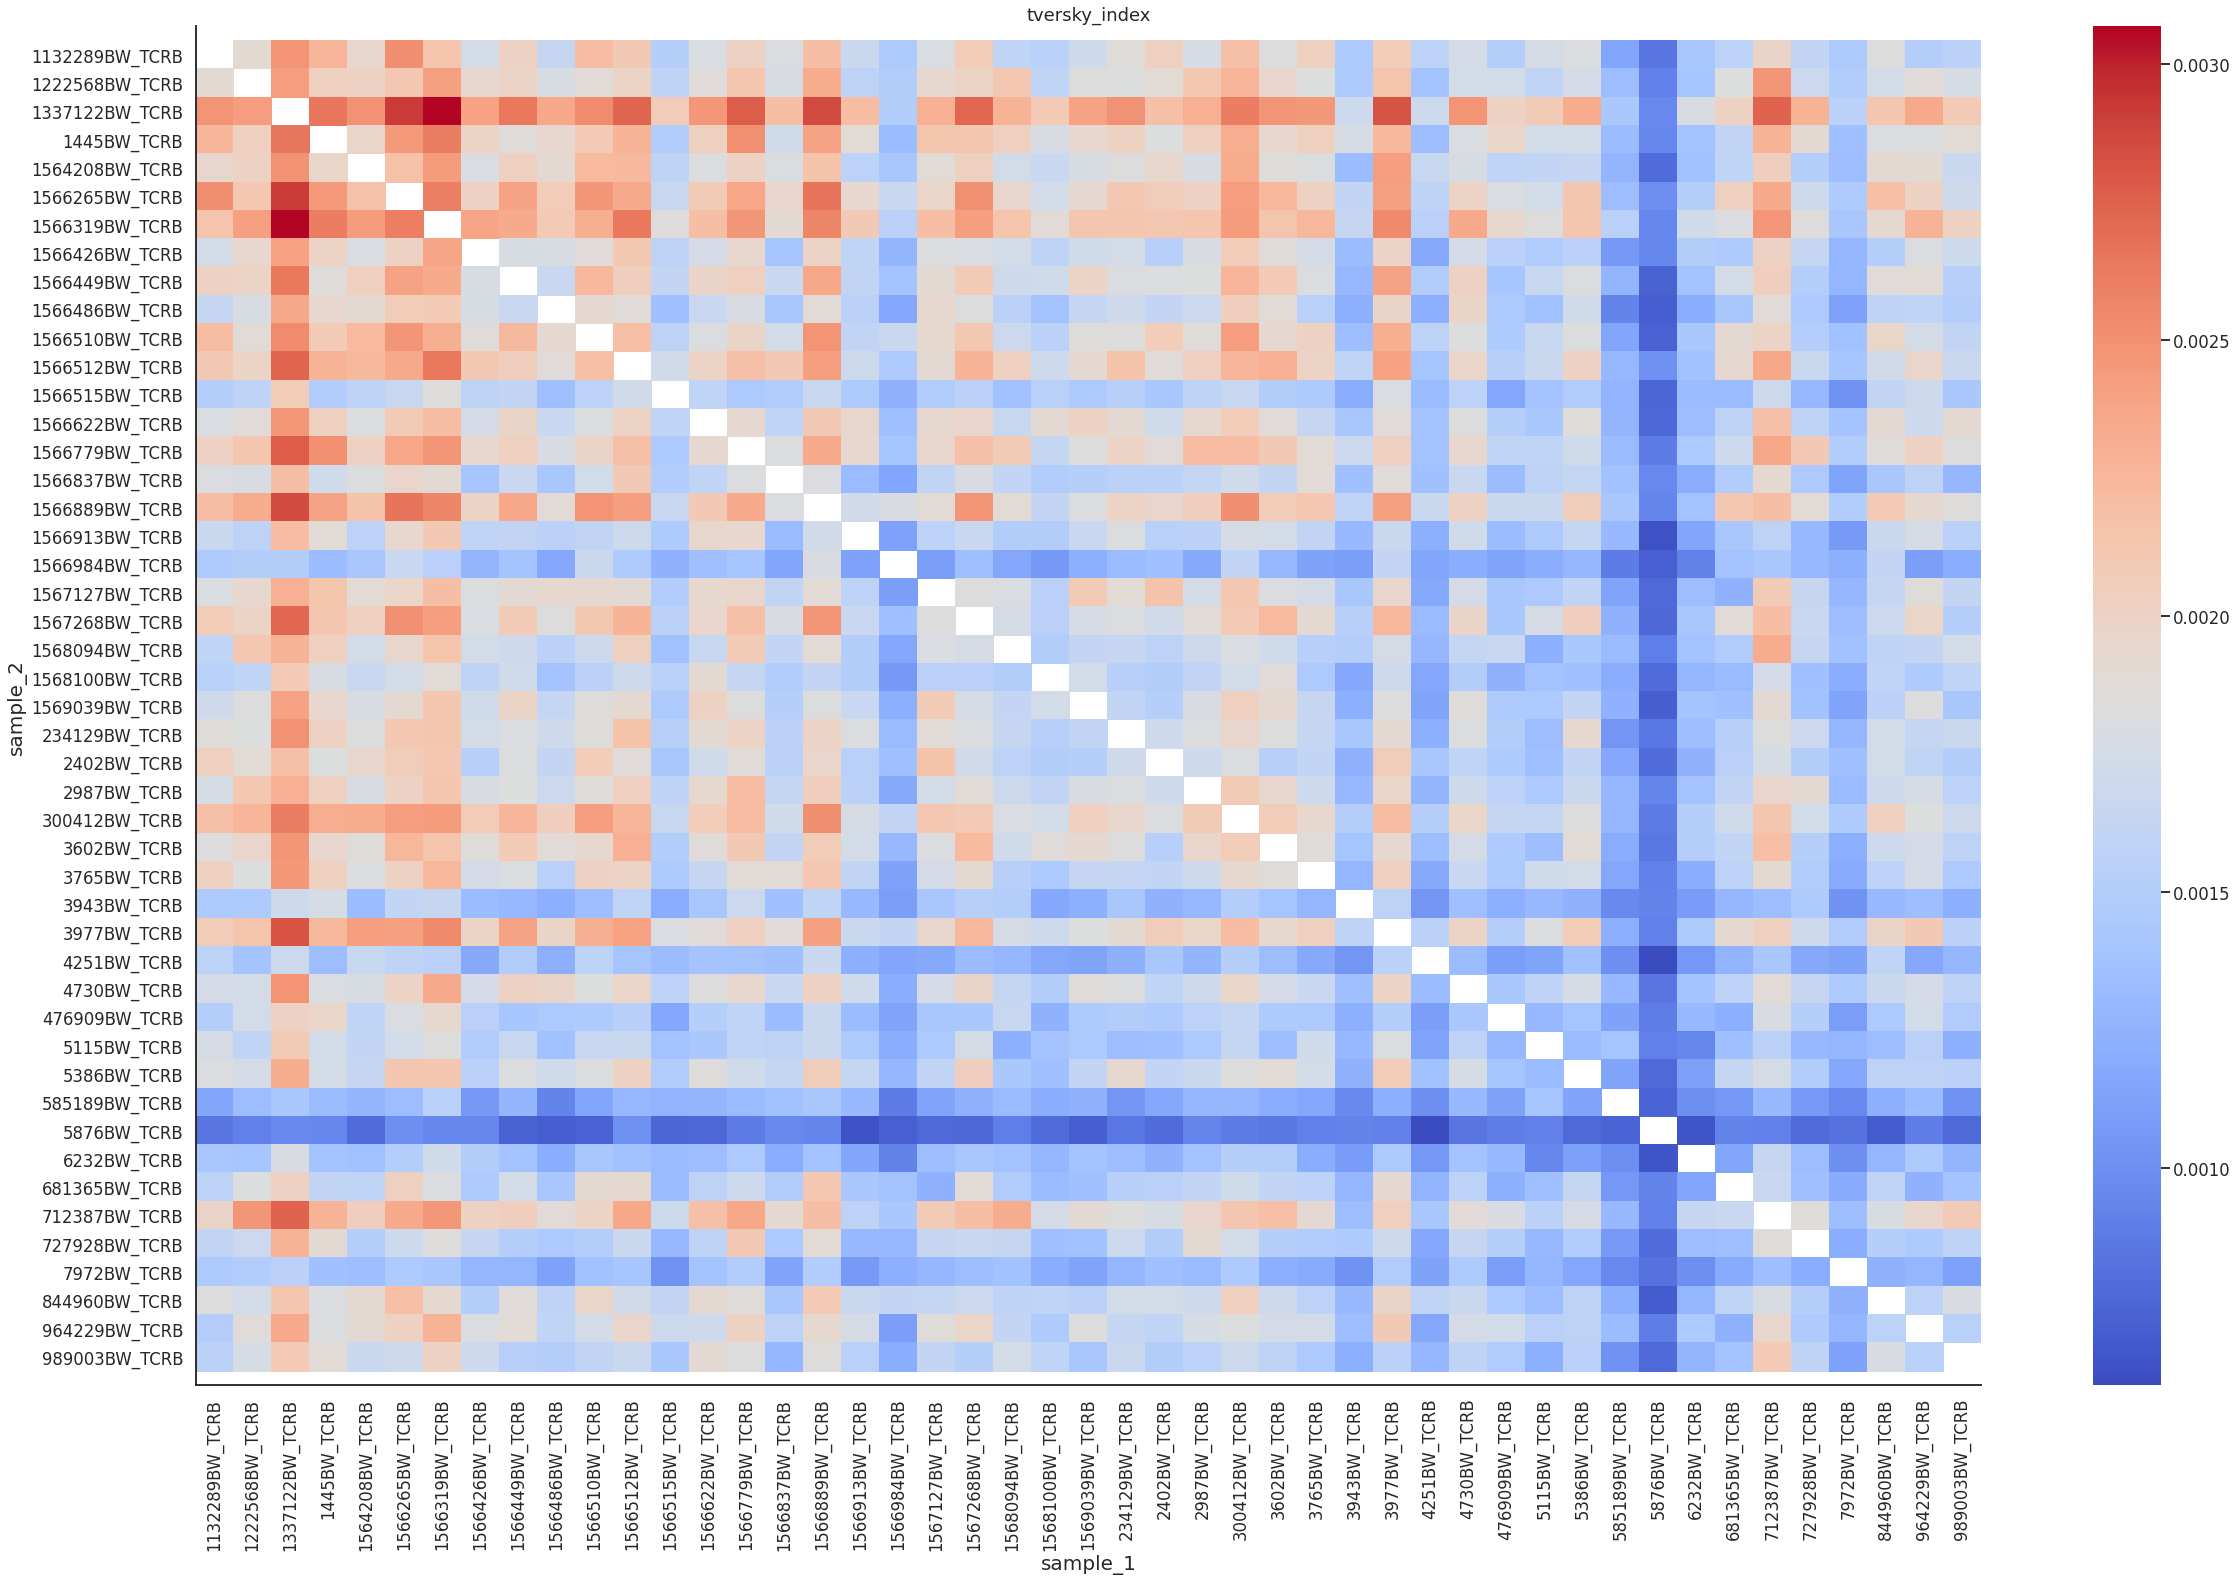

In [15]:
#set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40,25))
sns.set_style("white")
sns.set_context("talk")

#generate axes
df_tversky_index['Tversky_index'] = df_tversky_index['tversky_index'].astype(float)
result = df_tversky_index.pivot(index='sample_2',columns='sample_1',values='tversky_index')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1',fontsize=20)
ax.set_ylabel('sample_2',fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('tversky_index')

Overlap analysis 5.1 - Cosine similarity (result table)

In [16]:
from scipy.spatial.distance import cosine

columns = ['sample_1', 'sample_2', 'cosine_similarity']
df_cosine_similarity = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        cos_vec = (1 - cosine(df_overlap["freq_1"], df_overlap["freq_2"]))

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'cosine_similarity': cos_vec})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'cosine_similarity': cos_vec})

    df_data = pd.DataFrame(data)
    df_cosine_similarity = pd.concat(
        [df_cosine_similarity, df_data], copy=False, ignore_index=True)

display(df_cosine_similarity)


,sample_1,sample_2,cosine_similarity
0,6232BW_TCRB,5115BW_TCRB,0.352216
1,5115BW_TCRB,6232BW_TCRB,0.352216
2,6232BW_TCRB,989003BW_TCRB,0.203431
3,989003BW_TCRB,6232BW_TCRB,0.203431
4,6232BW_TCRB,7972BW_TCRB,0.157580
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.066429
2158,1566449BW_TCRB,1566265BW_TCRB,0.217962
2159,1566265BW_TCRB,1566449BW_TCRB,0.217962
2160,3602BW_TCRB,1566265BW_TCRB,0.177322


Overlap analysis 5.2 - Cosine similarity (heatmap)

Text(0.5, 1.0, 'cosine_similarity')

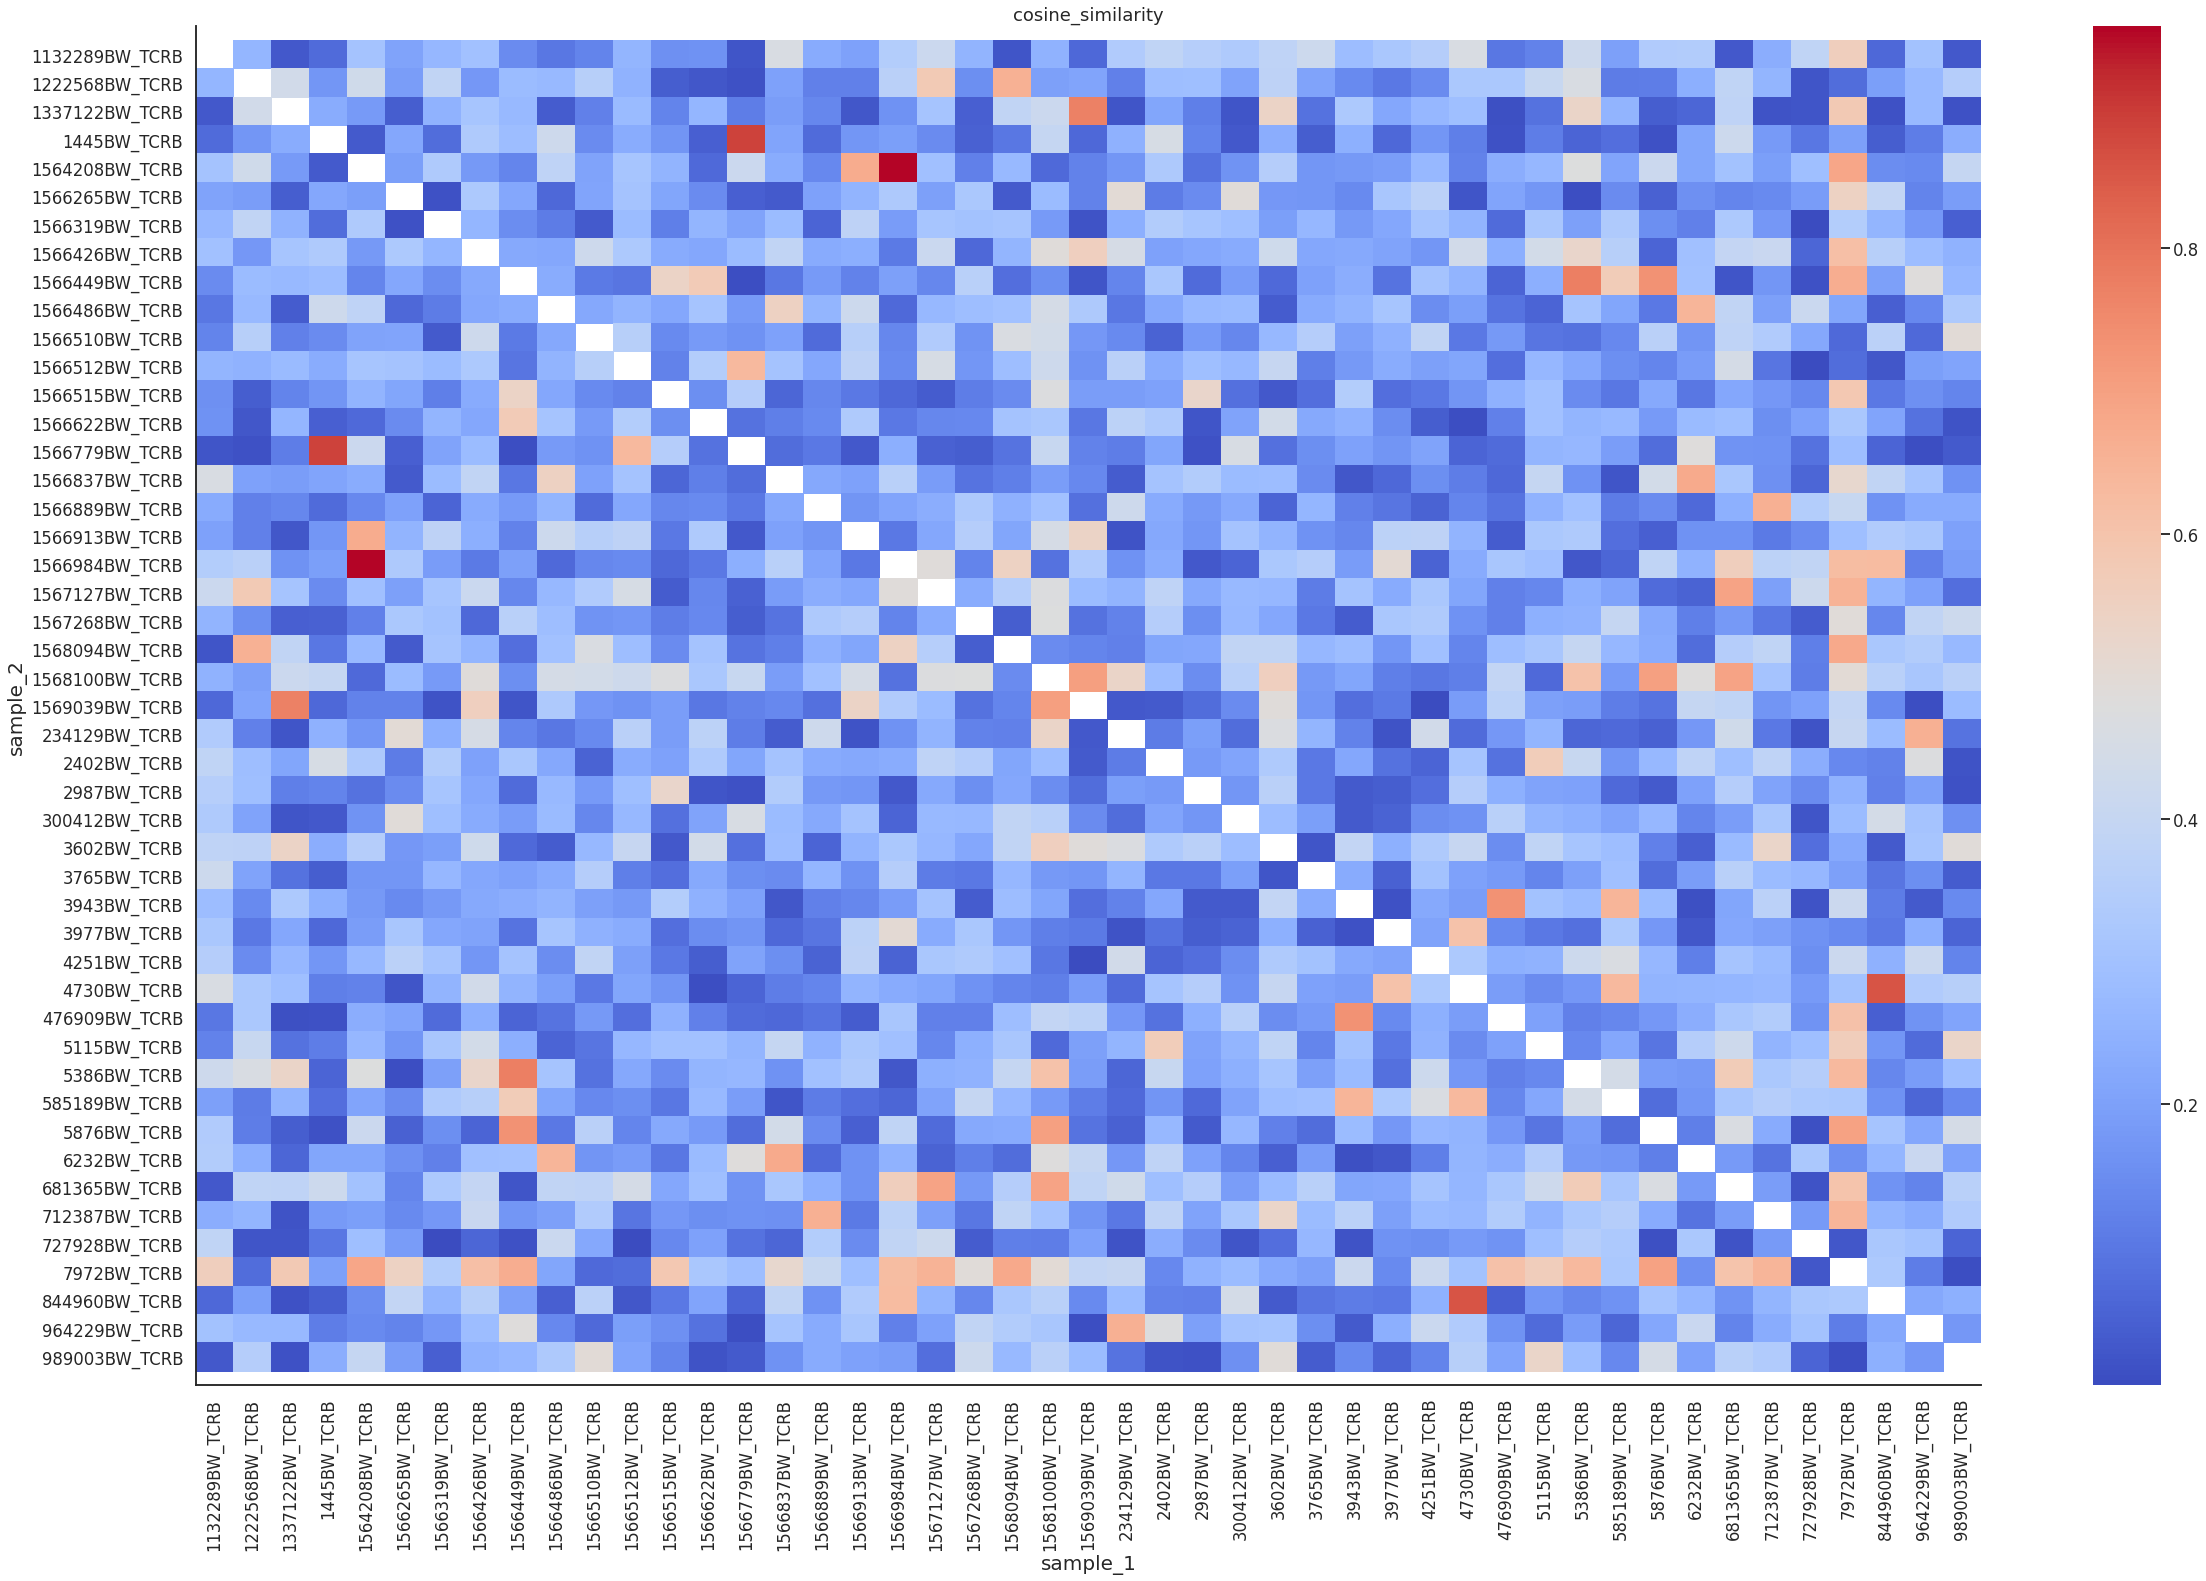

In [17]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_cosine_similarity['cosine_similarity'] = df_cosine_similarity['cosine_similarity'].astype(
    float)

result = df_cosine_similarity.pivot(
    index='sample_2', columns='sample_1', values='cosine_similarity')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('cosine_similarity')


Overlap analysis 6.1.1 - Pearson correlation based on clonotype counts (result table)

In [18]:
columns = ['sample_1', 'sample_2', 'pearson_correlation']
df_pearson_correlation_count = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation = df_overlap['#count_1'].corr(
            df_overlap['#count_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'pearson_correlation': pearson_correlation})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'pearson_correlation': pearson_correlation})

    df_data = pd.DataFrame(data)
    df_pearson_correlation_count = pd.concat(
        [df_pearson_correlation_count, df_data], copy=False, ignore_index=True)

display(df_pearson_correlation_count)


,sample_1,sample_2,pearson_correlation
0,6232BW_TCRB,5115BW_TCRB,0.129897
1,5115BW_TCRB,6232BW_TCRB,0.129897
2,6232BW_TCRB,989003BW_TCRB,-0.011675
3,989003BW_TCRB,6232BW_TCRB,-0.011675
4,6232BW_TCRB,7972BW_TCRB,-0.011471
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.049247
2158,1566449BW_TCRB,1566265BW_TCRB,0.125340
2159,1566265BW_TCRB,1566449BW_TCRB,0.125340
2160,3602BW_TCRB,1566265BW_TCRB,0.021052


Overlap analysis 6.1.2 - Pearson correlation based on clonotype counts (heatmap)

Text(0.5, 1.0, 'pearson_correlation')

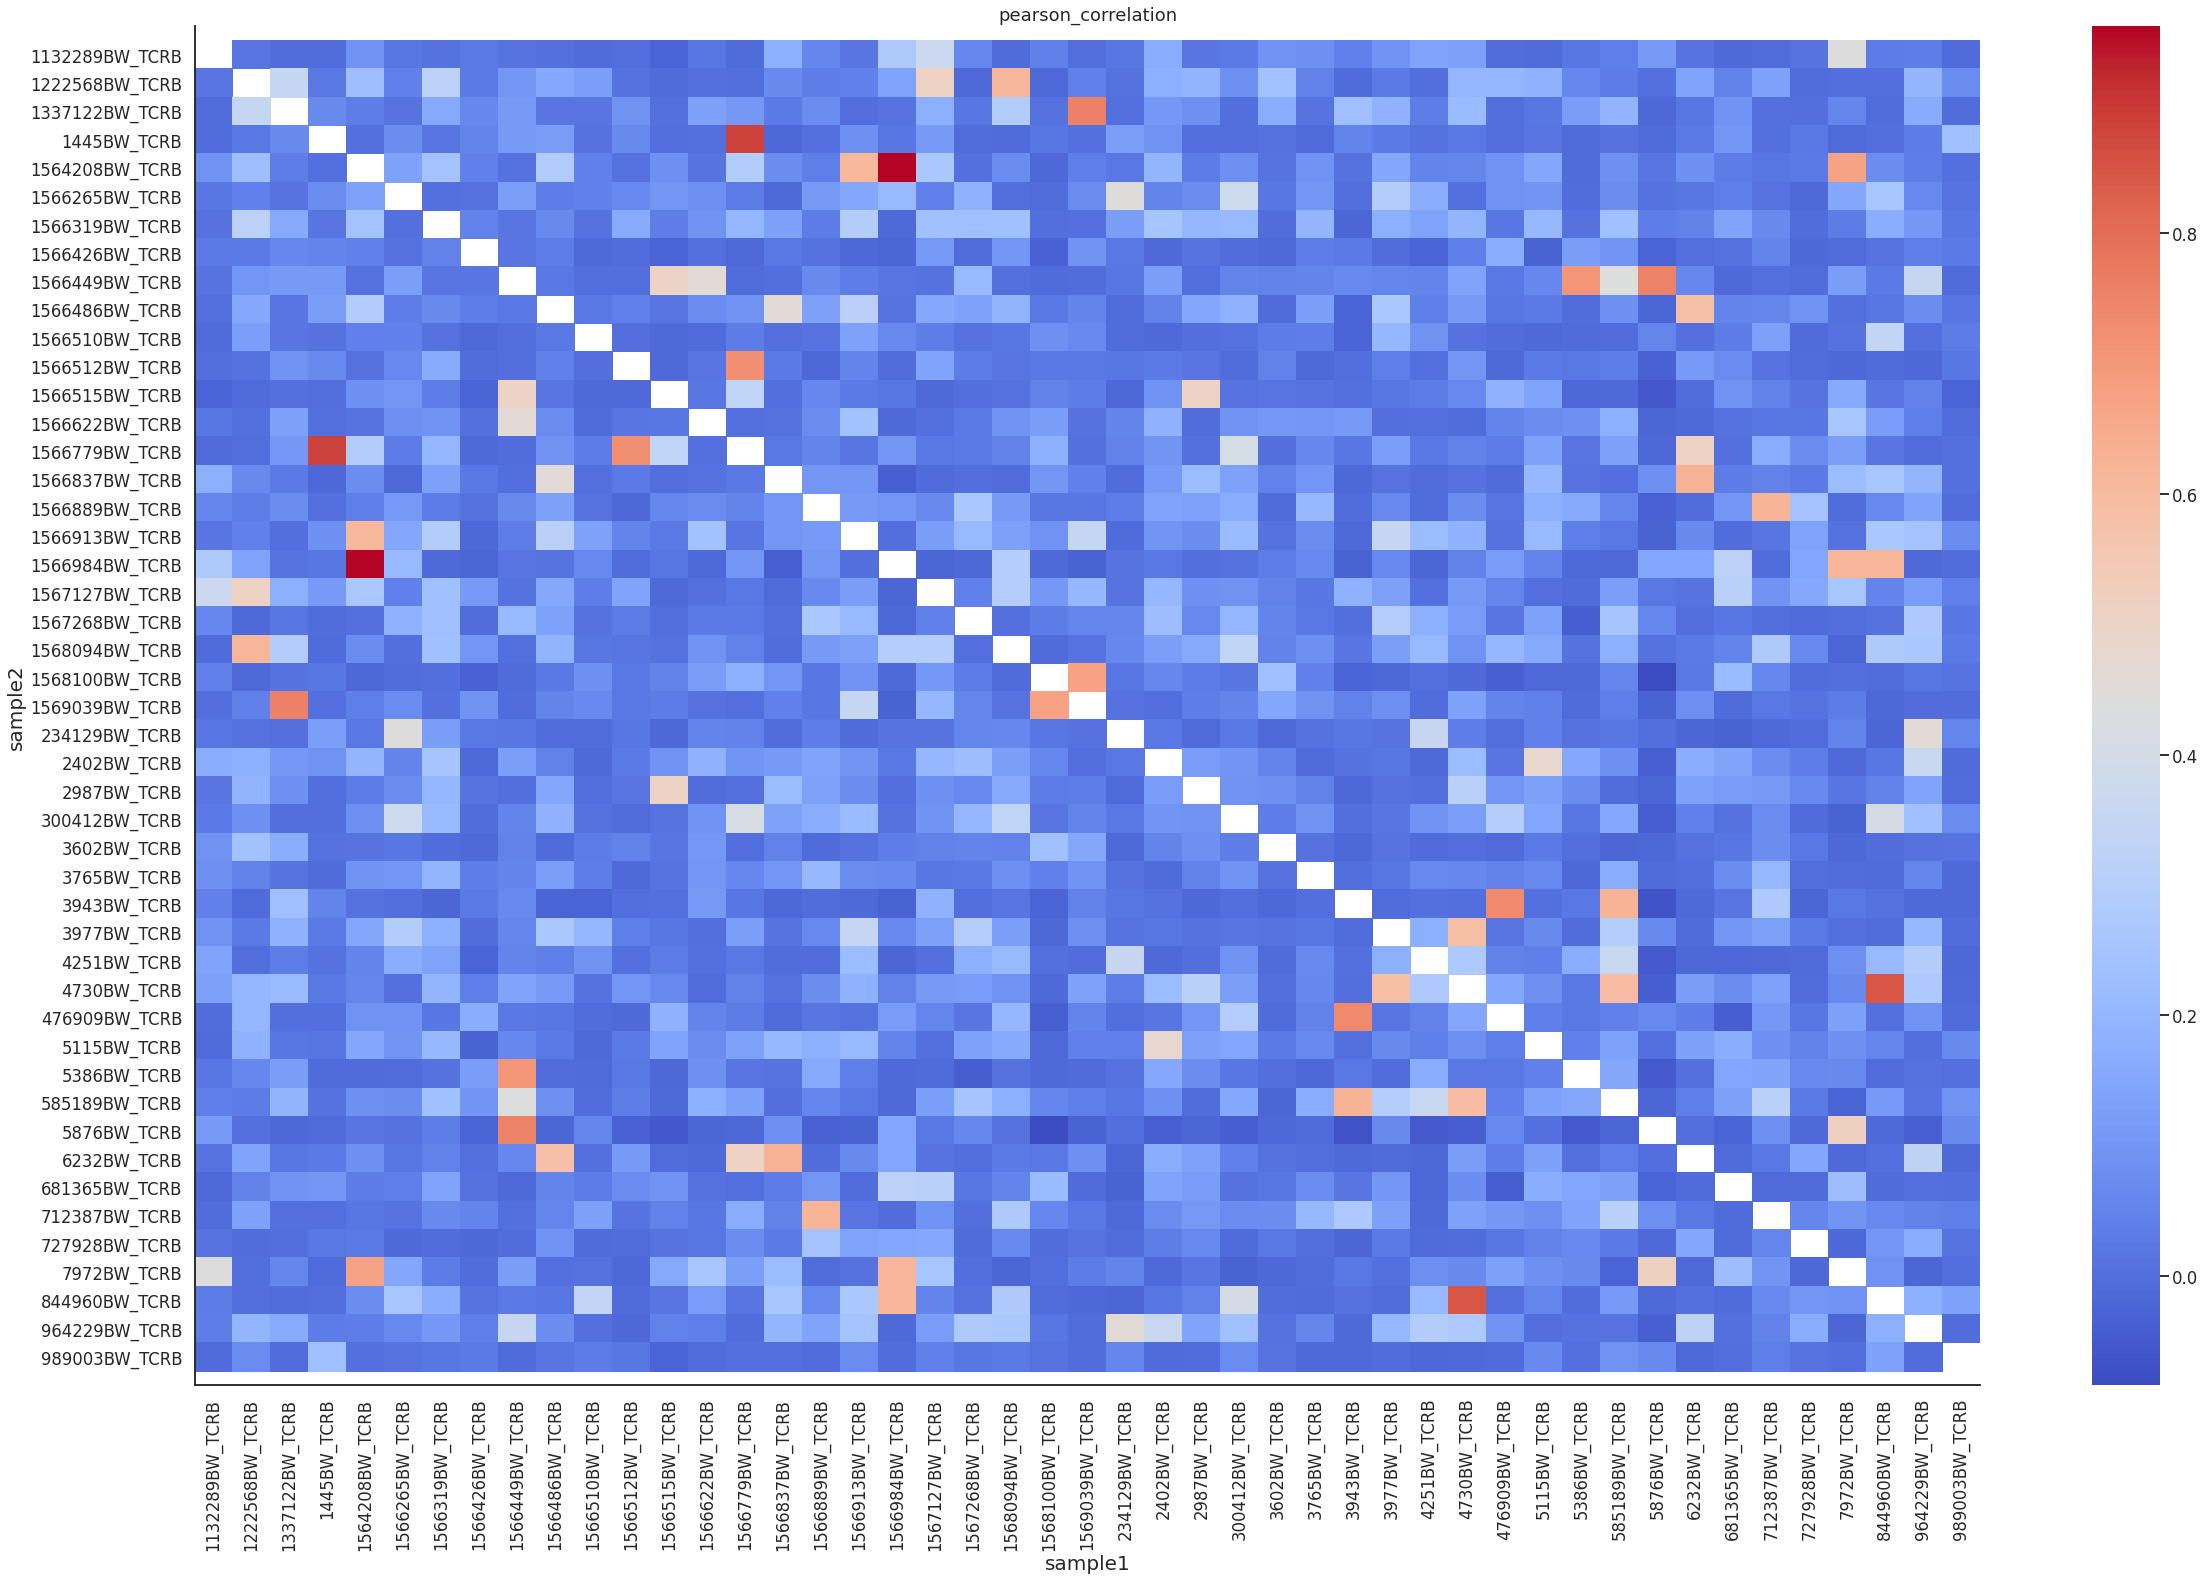

In [19]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_pearson_correlation_count['pearson_correlation'] = df_pearson_correlation_count['pearson_correlation'].astype(
    float)

result = df_pearson_correlation_count.pivot(
    index='sample_2', columns='sample_1', values='pearson_correlation')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample1', fontsize=20)
ax.set_ylabel('sample2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('pearson_correlation')


Overlap analysis 6.2.1 - Pearson correlation based on clonotype frequency (result table)

In [20]:
columns = ['sample_1', 'sample_2', 'pearson_correlation']
df_pearson_correlation_freq = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation_freq = df_overlap['freq_1'].corr(
            df_overlap['freq_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'pearson_correlation': pearson_correlation_freq})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'pearson_correlation': pearson_correlation_freq})

    df_data = pd.DataFrame(data)
    df_pearson_correlation_freq = pd.concat(
        [df_pearson_correlation_freq, df_data], copy=False, ignore_index=True)

display(df_pearson_correlation_freq)


,sample_1,sample_2,pearson_correlation
0,6232BW_TCRB,5115BW_TCRB,0.129897
1,5115BW_TCRB,6232BW_TCRB,0.129897
2,6232BW_TCRB,989003BW_TCRB,-0.011675
3,989003BW_TCRB,6232BW_TCRB,-0.011675
4,6232BW_TCRB,7972BW_TCRB,-0.011471
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.049247
2158,1566449BW_TCRB,1566265BW_TCRB,0.125340
2159,1566265BW_TCRB,1566449BW_TCRB,0.125340
2160,3602BW_TCRB,1566265BW_TCRB,0.021052


Overlap analysis 6.2.2 - Pearson correlation based on clonotype frequency (heatmap)

Text(0.5, 1.0, 'pearson_correlation')

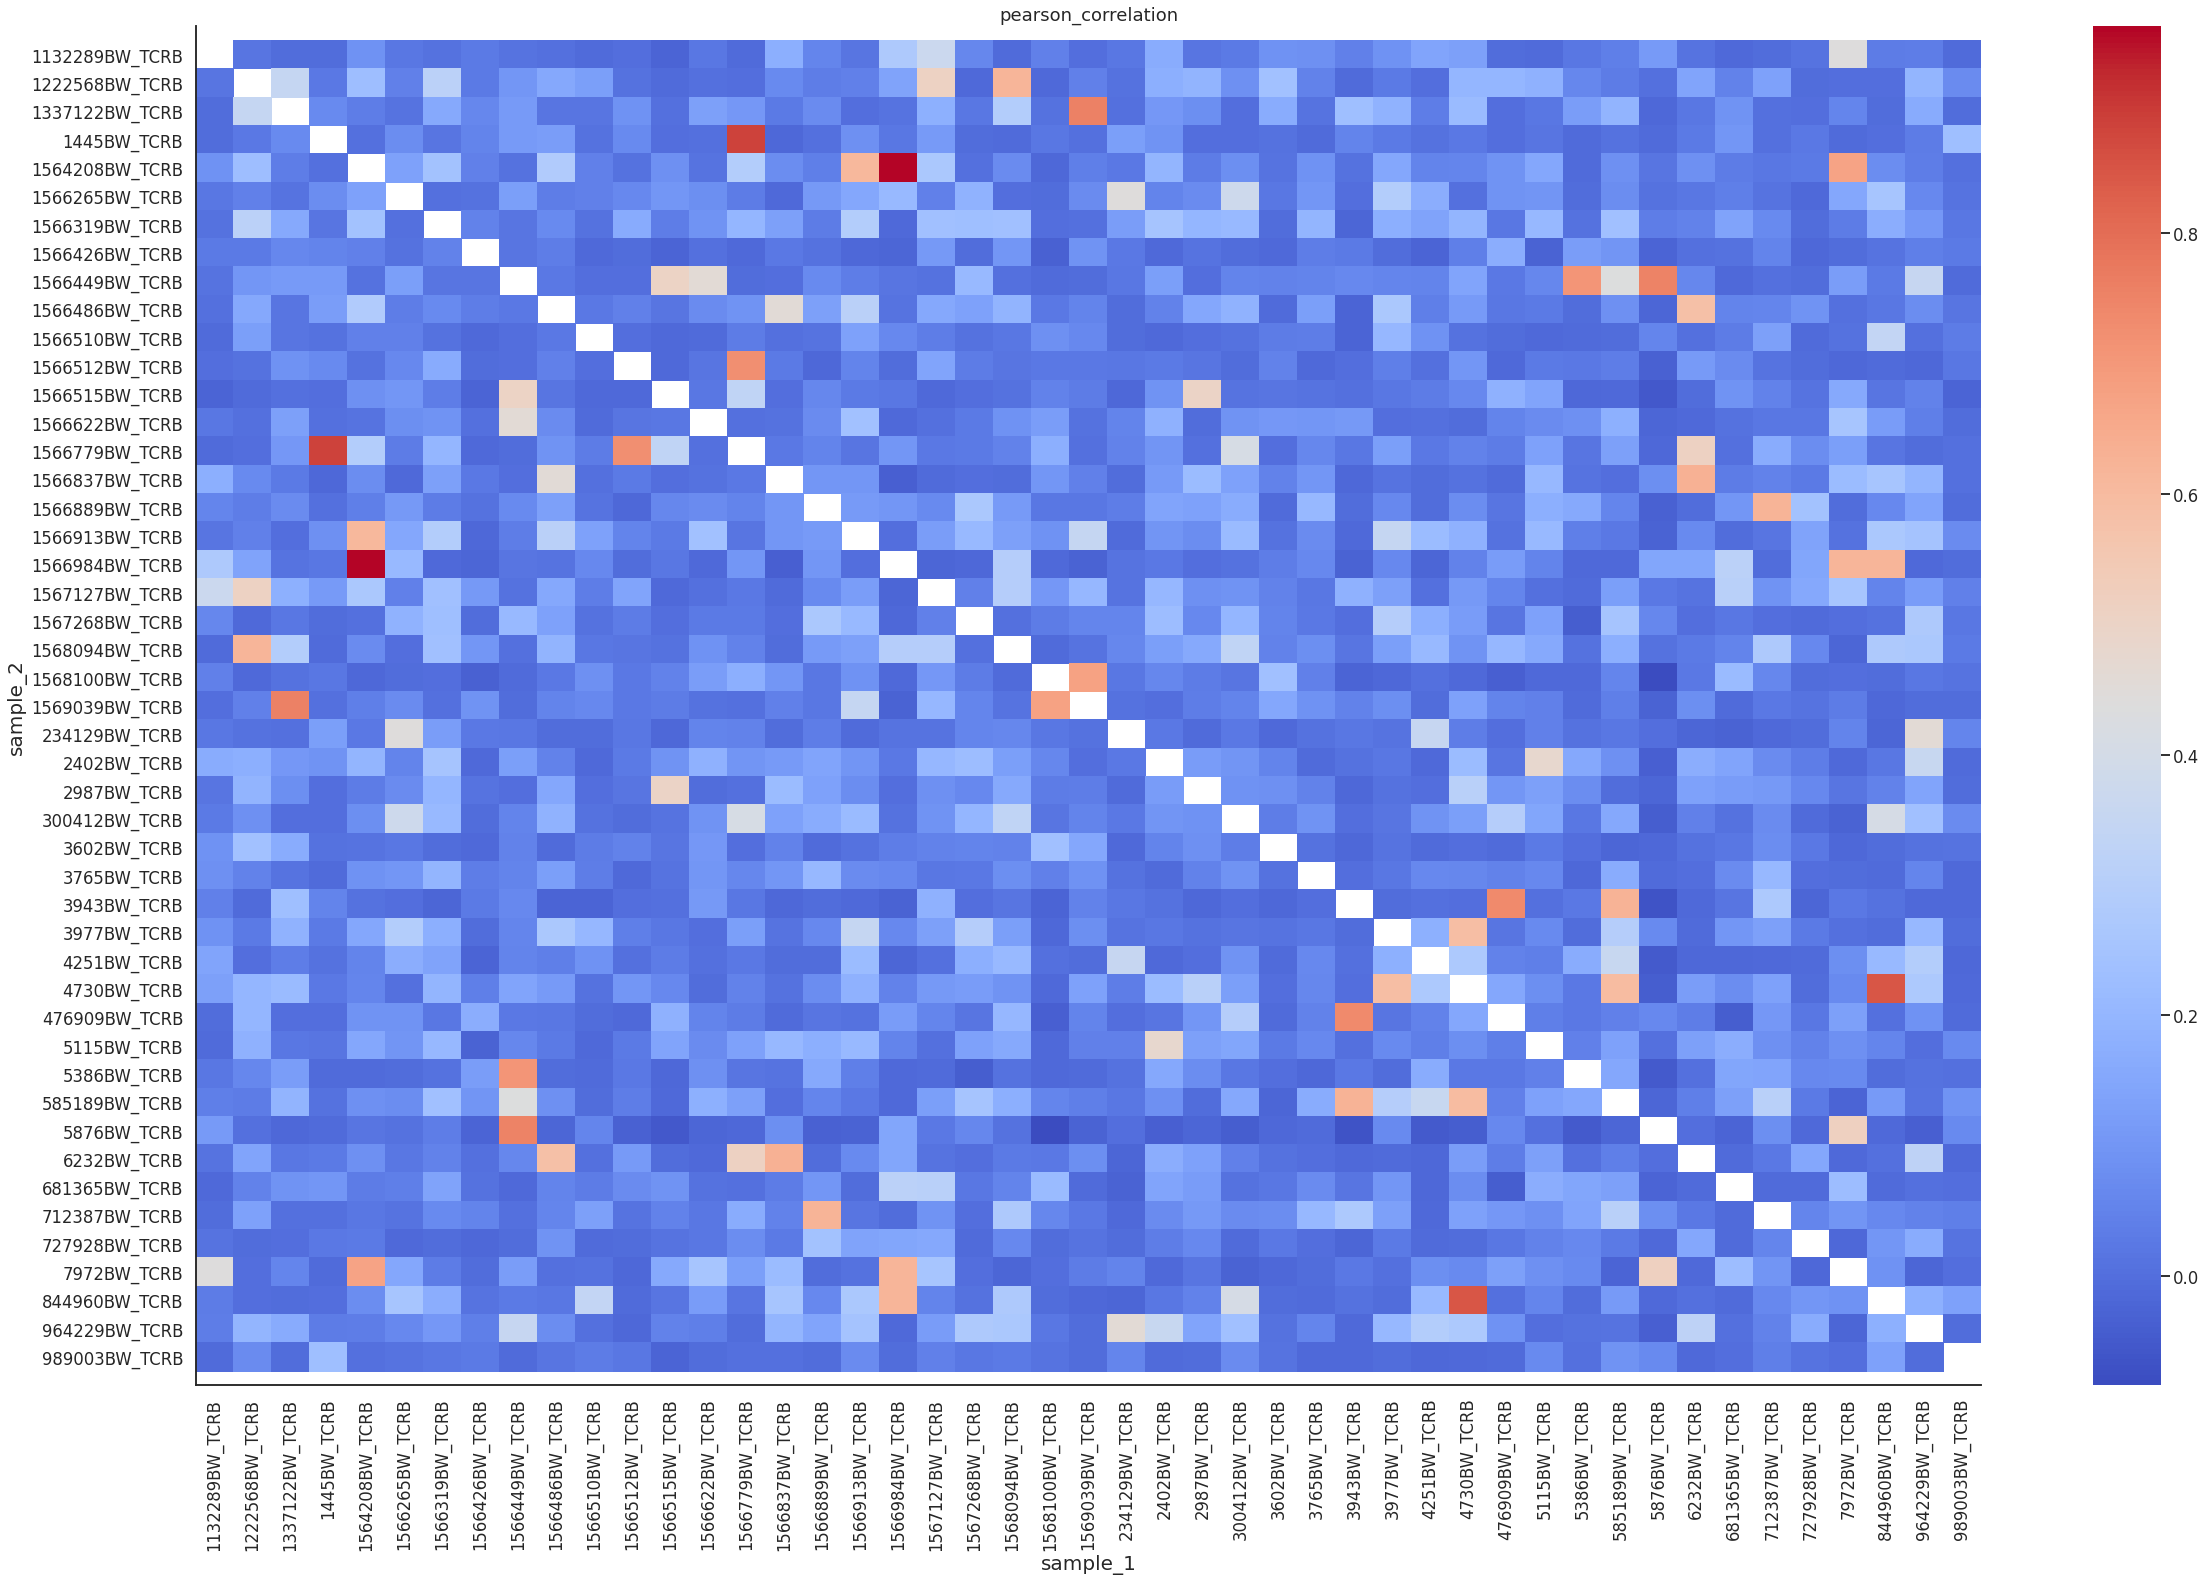

In [21]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_pearson_correlation_freq['pearson_correlation'] = df_pearson_correlation_freq['pearson_correlation'].astype(
    float)
result = df_pearson_correlation_freq.pivot(
    index='sample_2', columns='sample_1', values='pearson_correlation')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('pearson_correlation')


Overlap analysis 7.1 - Relative overlap diversity (result table)

In [22]:
columns = ['sample_1', 'sample_2', 'relative_overlap_diversity']
df_relative_overlap_diversity = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        relative_overlap_diversity = df_overlap.shape[0] / (
            df_sample1.shape[0] * df_sample2.shape[0])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'relative_overlap_diversity': relative_overlap_diversity})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'relative_overlap_diversity': relative_overlap_diversity})

    df_data = pd.DataFrame(data)
    df_relative_overlap_diversity = pd.concat(
        [df_relative_overlap_diversity, df_data], copy=False, ignore_index=True)

display(df_relative_overlap_diversity)


,sample_1,sample_2,relative_overlap_diversity
0,6232BW_TCRB,5115BW_TCRB,4.317742e-09
1,5115BW_TCRB,6232BW_TCRB,4.317742e-09
2,6232BW_TCRB,989003BW_TCRB,4.831447e-09
3,989003BW_TCRB,6232BW_TCRB,4.831447e-09
4,6232BW_TCRB,7972BW_TCRB,5.158763e-09
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,5.595345e-09
2158,1566449BW_TCRB,1566265BW_TCRB,5.889200e-09
2159,1566265BW_TCRB,1566449BW_TCRB,5.889200e-09
2160,3602BW_TCRB,1566265BW_TCRB,5.443067e-09


Overlap analysis 7.2 - Relative overlap diversity (heatmap)

Text(0.5, 1.0, 'relative_overlap_diversity')

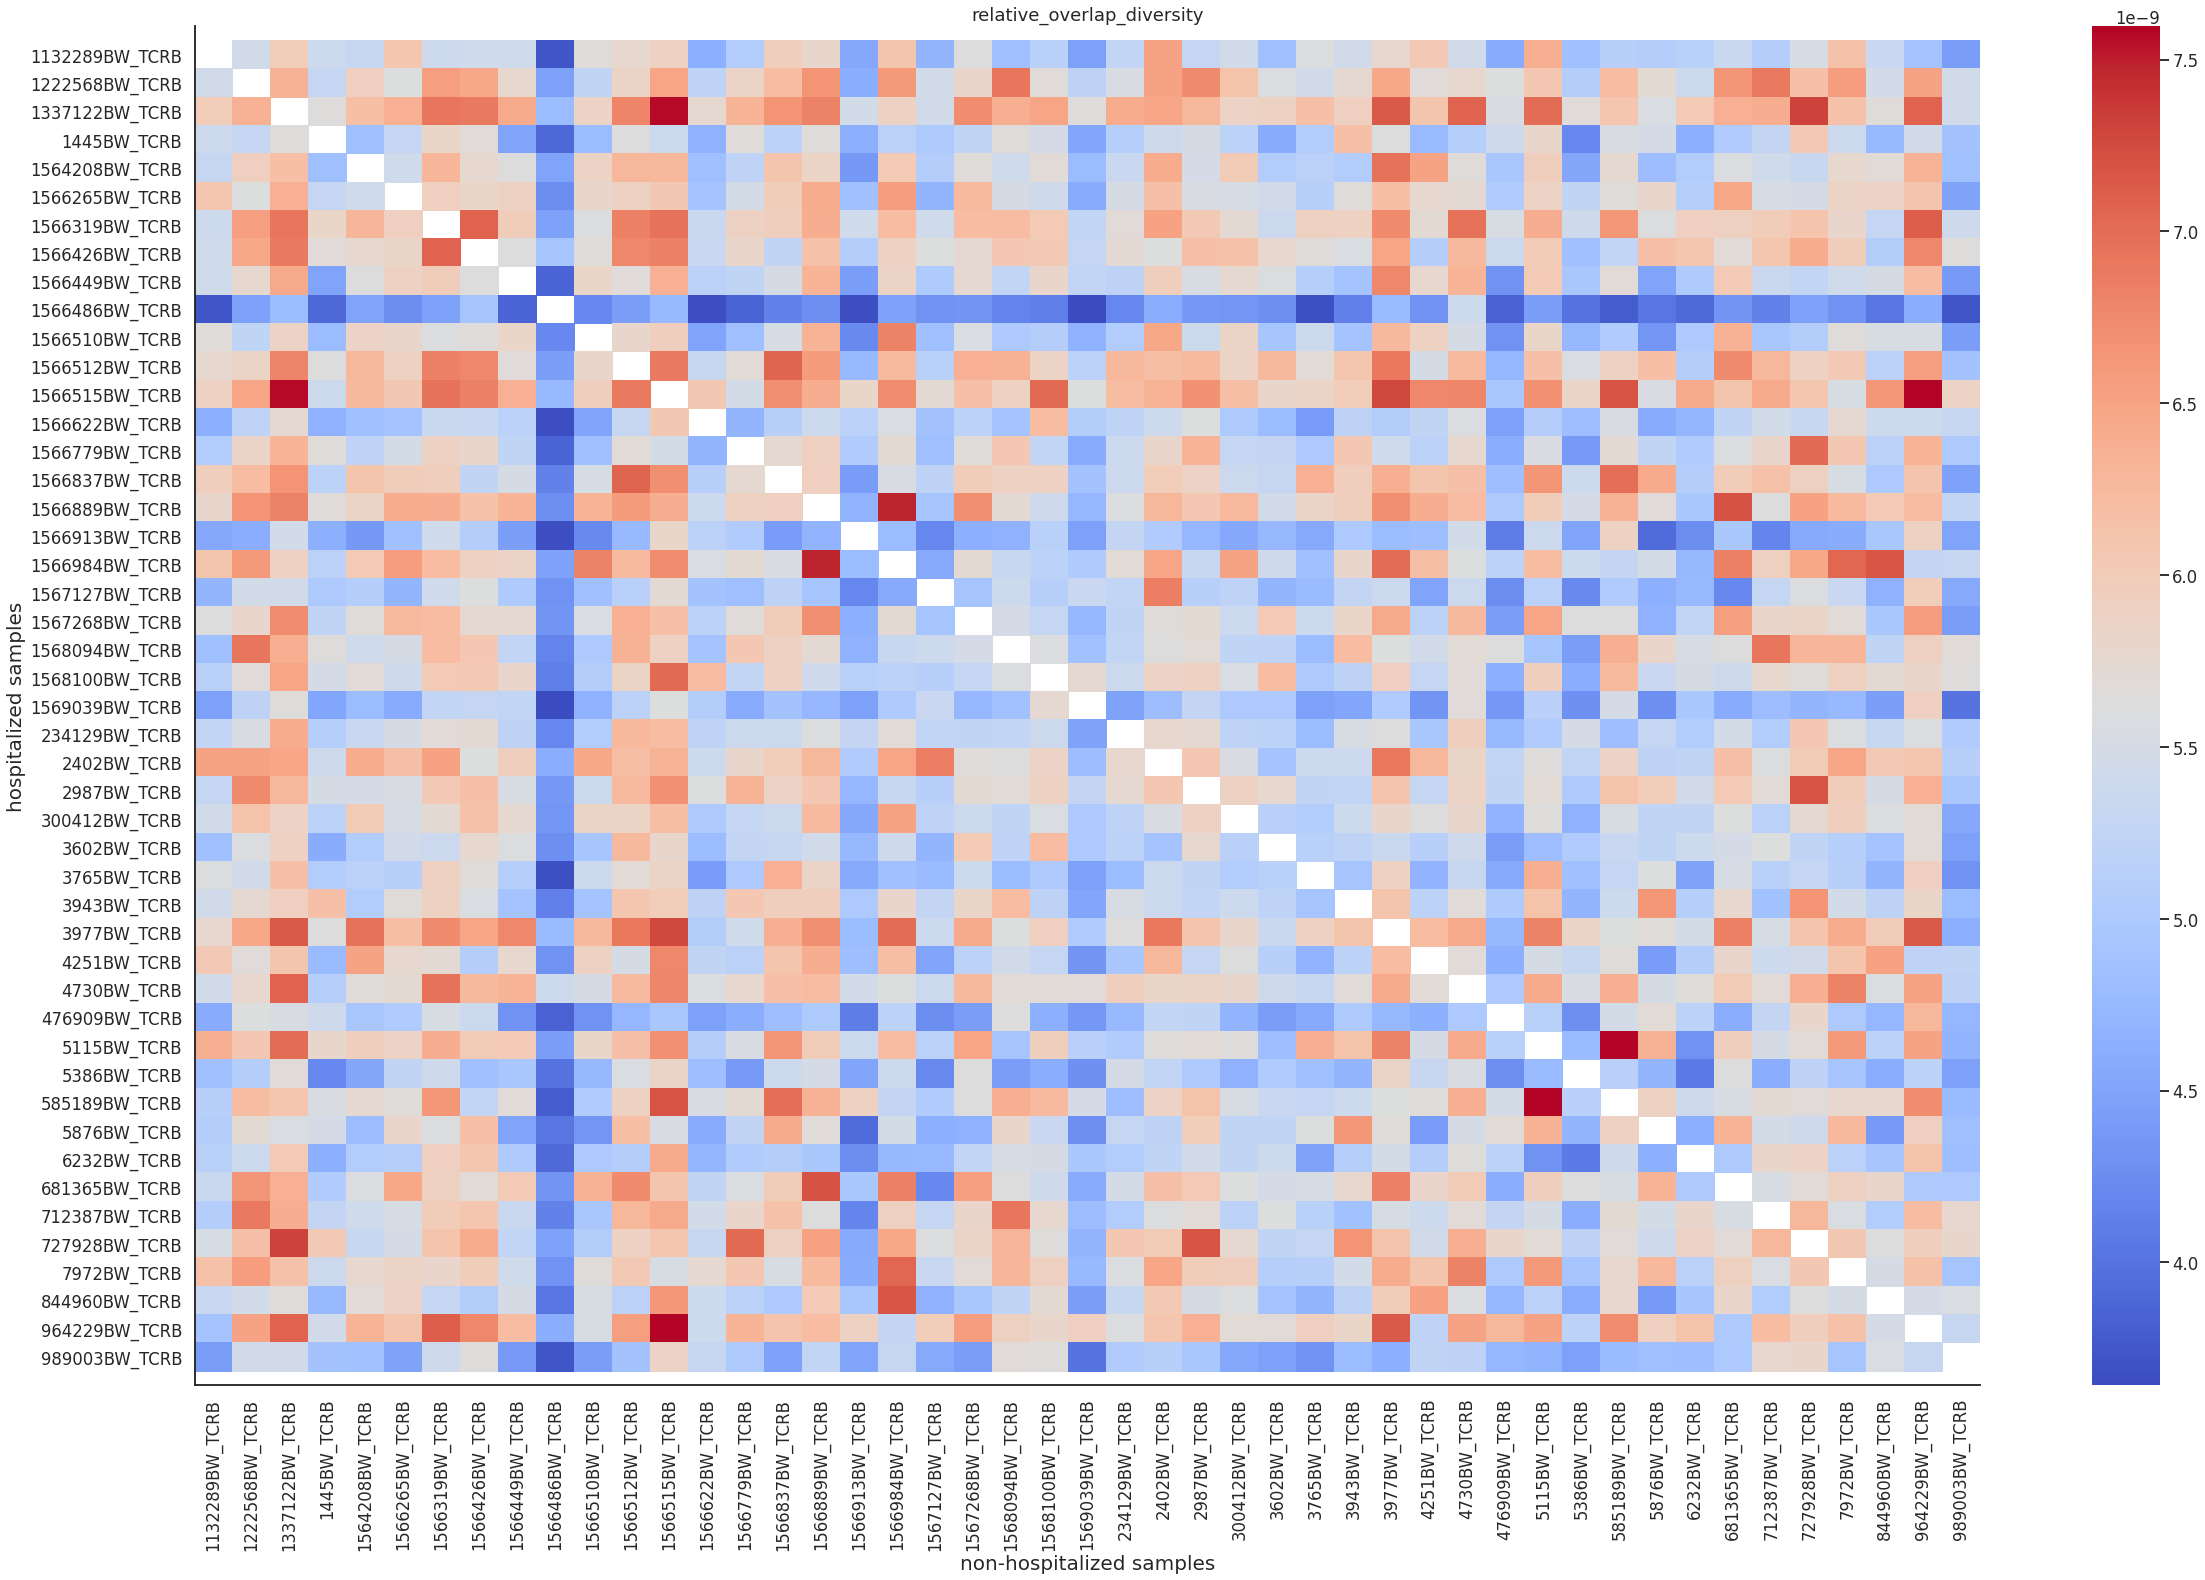

In [23]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_relative_overlap_diversity['relative_overlap_diversity'] = df_relative_overlap_diversity['relative_overlap_diversity'].astype(
    float)
result = df_relative_overlap_diversity.pivot(
    index='sample_2', columns='sample_1', values='relative_overlap_diversity')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('non-hospitalized samples', fontsize=20)
ax.set_ylabel('hospitalized samples', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('relative_overlap_diversity')


Overlap analysis 8.1 - Geometric mean of relative overlap frequencies (result table)

In [24]:
columns = ['sample_1', 'sample_2',
           'geometric_mean_of_relative_overlap_frequencies']

df_geometric_mean_of_relative_overlap_frequencies = pd.DataFrame(
    columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = (df_overlap['freq_1'].sum() * df_overlap['freq_2'].sum())**0.5

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'geometric_mean_of_relative_overlap_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'geometric_mean_of_relative_overlap_frequencies': result})

    df_data = pd.DataFrame(data)
    df_geometric_mean_of_relative_overlap_frequencies = pd.concat(
        [df_geometric_mean_of_relative_overlap_frequencies, df_data], copy=False, ignore_index=True)

df_geometric_mean_of_relative_overlap_frequencies


,sample_1,sample_2,geometric_mean_of_relative_overlap_frequencies
0,6232BW_TCRB,5115BW_TCRB,0.000568
1,5115BW_TCRB,6232BW_TCRB,0.000568
2,6232BW_TCRB,989003BW_TCRB,0.001063
3,989003BW_TCRB,6232BW_TCRB,0.001063
4,6232BW_TCRB,7972BW_TCRB,0.000952
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.002468
2158,1566449BW_TCRB,1566265BW_TCRB,0.002458
2159,1566265BW_TCRB,1566449BW_TCRB,0.002458
2160,3602BW_TCRB,1566265BW_TCRB,0.001893


Overlap analysis 8.2 - Geometric mean of relative overlap frequencies (heatmap)

Text(0.5, 1.0, 'geometric_mean_of_relative_overlap_frequencies')

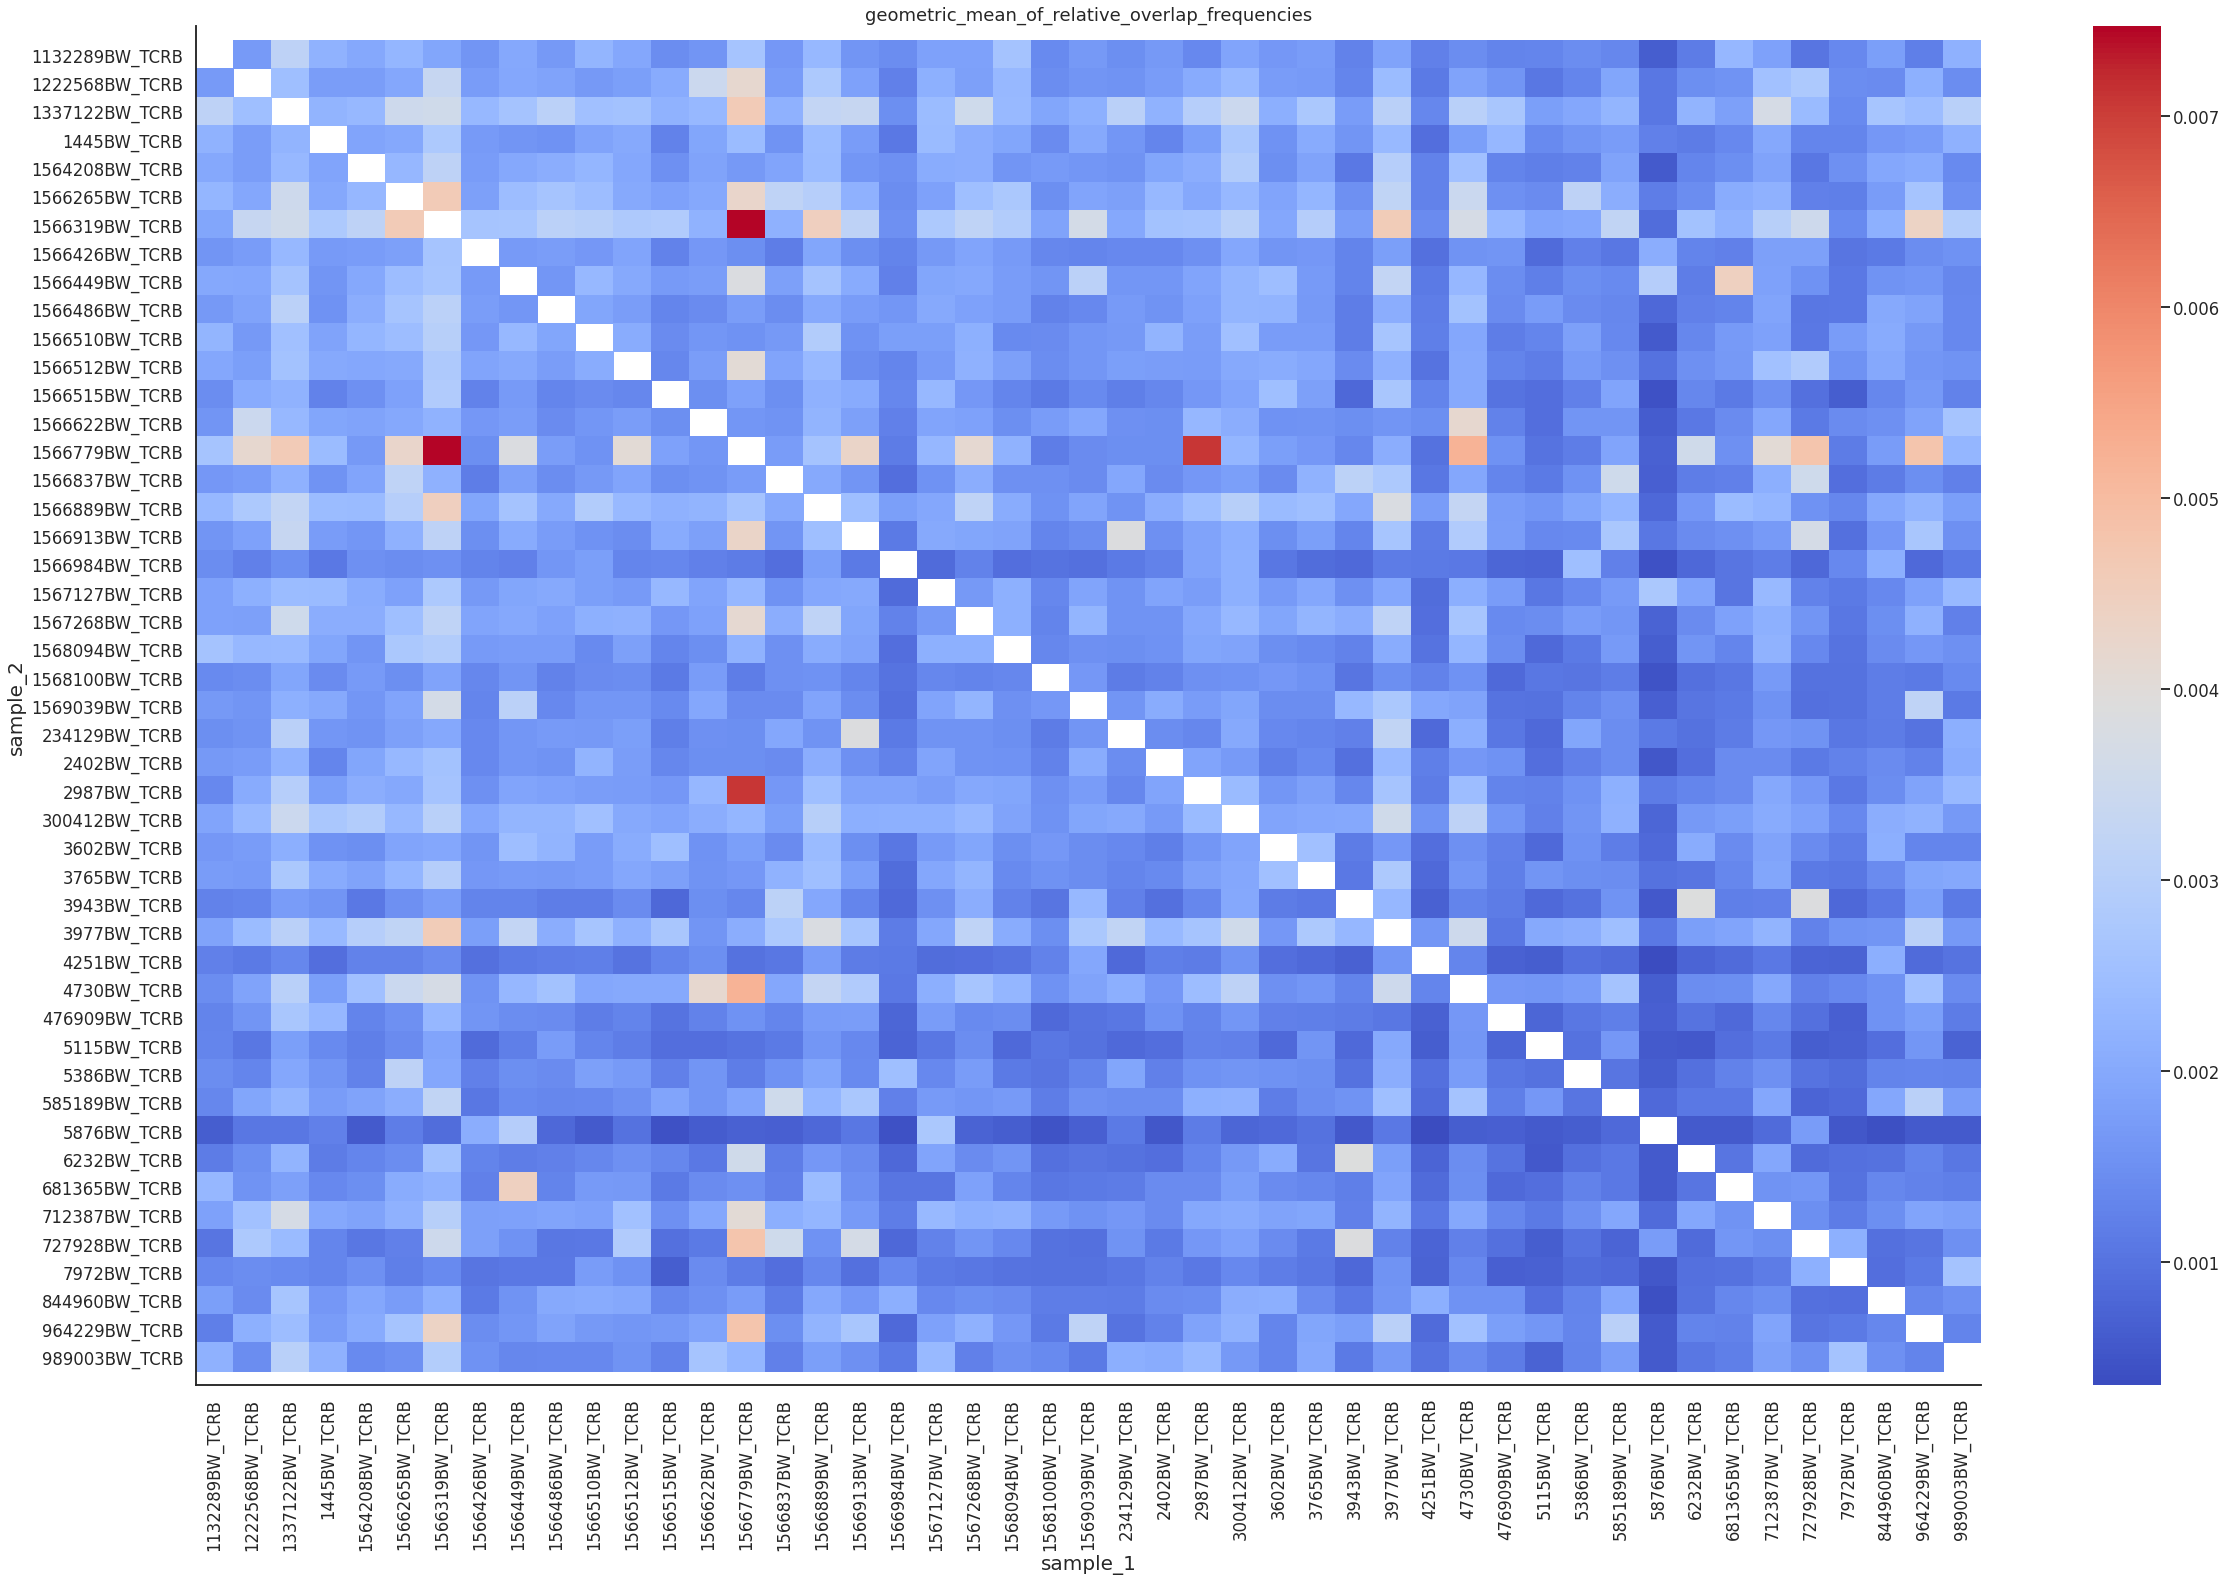

In [25]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_geometric_mean_of_relative_overlap_frequencies['geometric_mean_of_relative_overlap_frequencies'] = df_geometric_mean_of_relative_overlap_frequencies[
    'geometric_mean_of_relative_overlap_frequencies'].astype(float)
    
result = df_geometric_mean_of_relative_overlap_frequencies.pivot(
    index='sample_2', columns='sample_1', values='geometric_mean_of_relative_overlap_frequencies')
    
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('geometric_mean_of_relative_overlap_frequencies')


Overlap analysis 9.1 - Сlonotype-wise sum of geometric mean frequencies (result table)

In [26]:
columns = ['sample_1', 'sample_2',
           'clonotype_wise_sum_of_geometric_mean_frequencies']

df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.DataFrame(
    columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = ((df_overlap['freq_1']*df_overlap['freq_2'])**0.5).sum()

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})

    df_data = pd.DataFrame(data)
    df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.concat(
        [df_clonotype_wise_sum_of_geometric_mean_frequencies, df_data], copy=False, ignore_index=True)

df_clonotype_wise_sum_of_geometric_mean_frequencies


,sample_1,sample_2,clonotype_wise_sum_of_geometric_mean_frequencies
0,6232BW_TCRB,5115BW_TCRB,0.000480
1,5115BW_TCRB,6232BW_TCRB,0.000480
2,6232BW_TCRB,989003BW_TCRB,0.000876
3,989003BW_TCRB,6232BW_TCRB,0.000876
4,6232BW_TCRB,7972BW_TCRB,0.000741
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.001736
2158,1566449BW_TCRB,1566265BW_TCRB,0.001943
2159,1566265BW_TCRB,1566449BW_TCRB,0.001943
2160,3602BW_TCRB,1566265BW_TCRB,0.001634


Overlap analysis 9.2 - Clonotype-wise sum of geometric mean frequencies (heatmap)

Text(0.5, 1.0, 'clonotype_wise_sum_of_geometric_mean_frequencies')

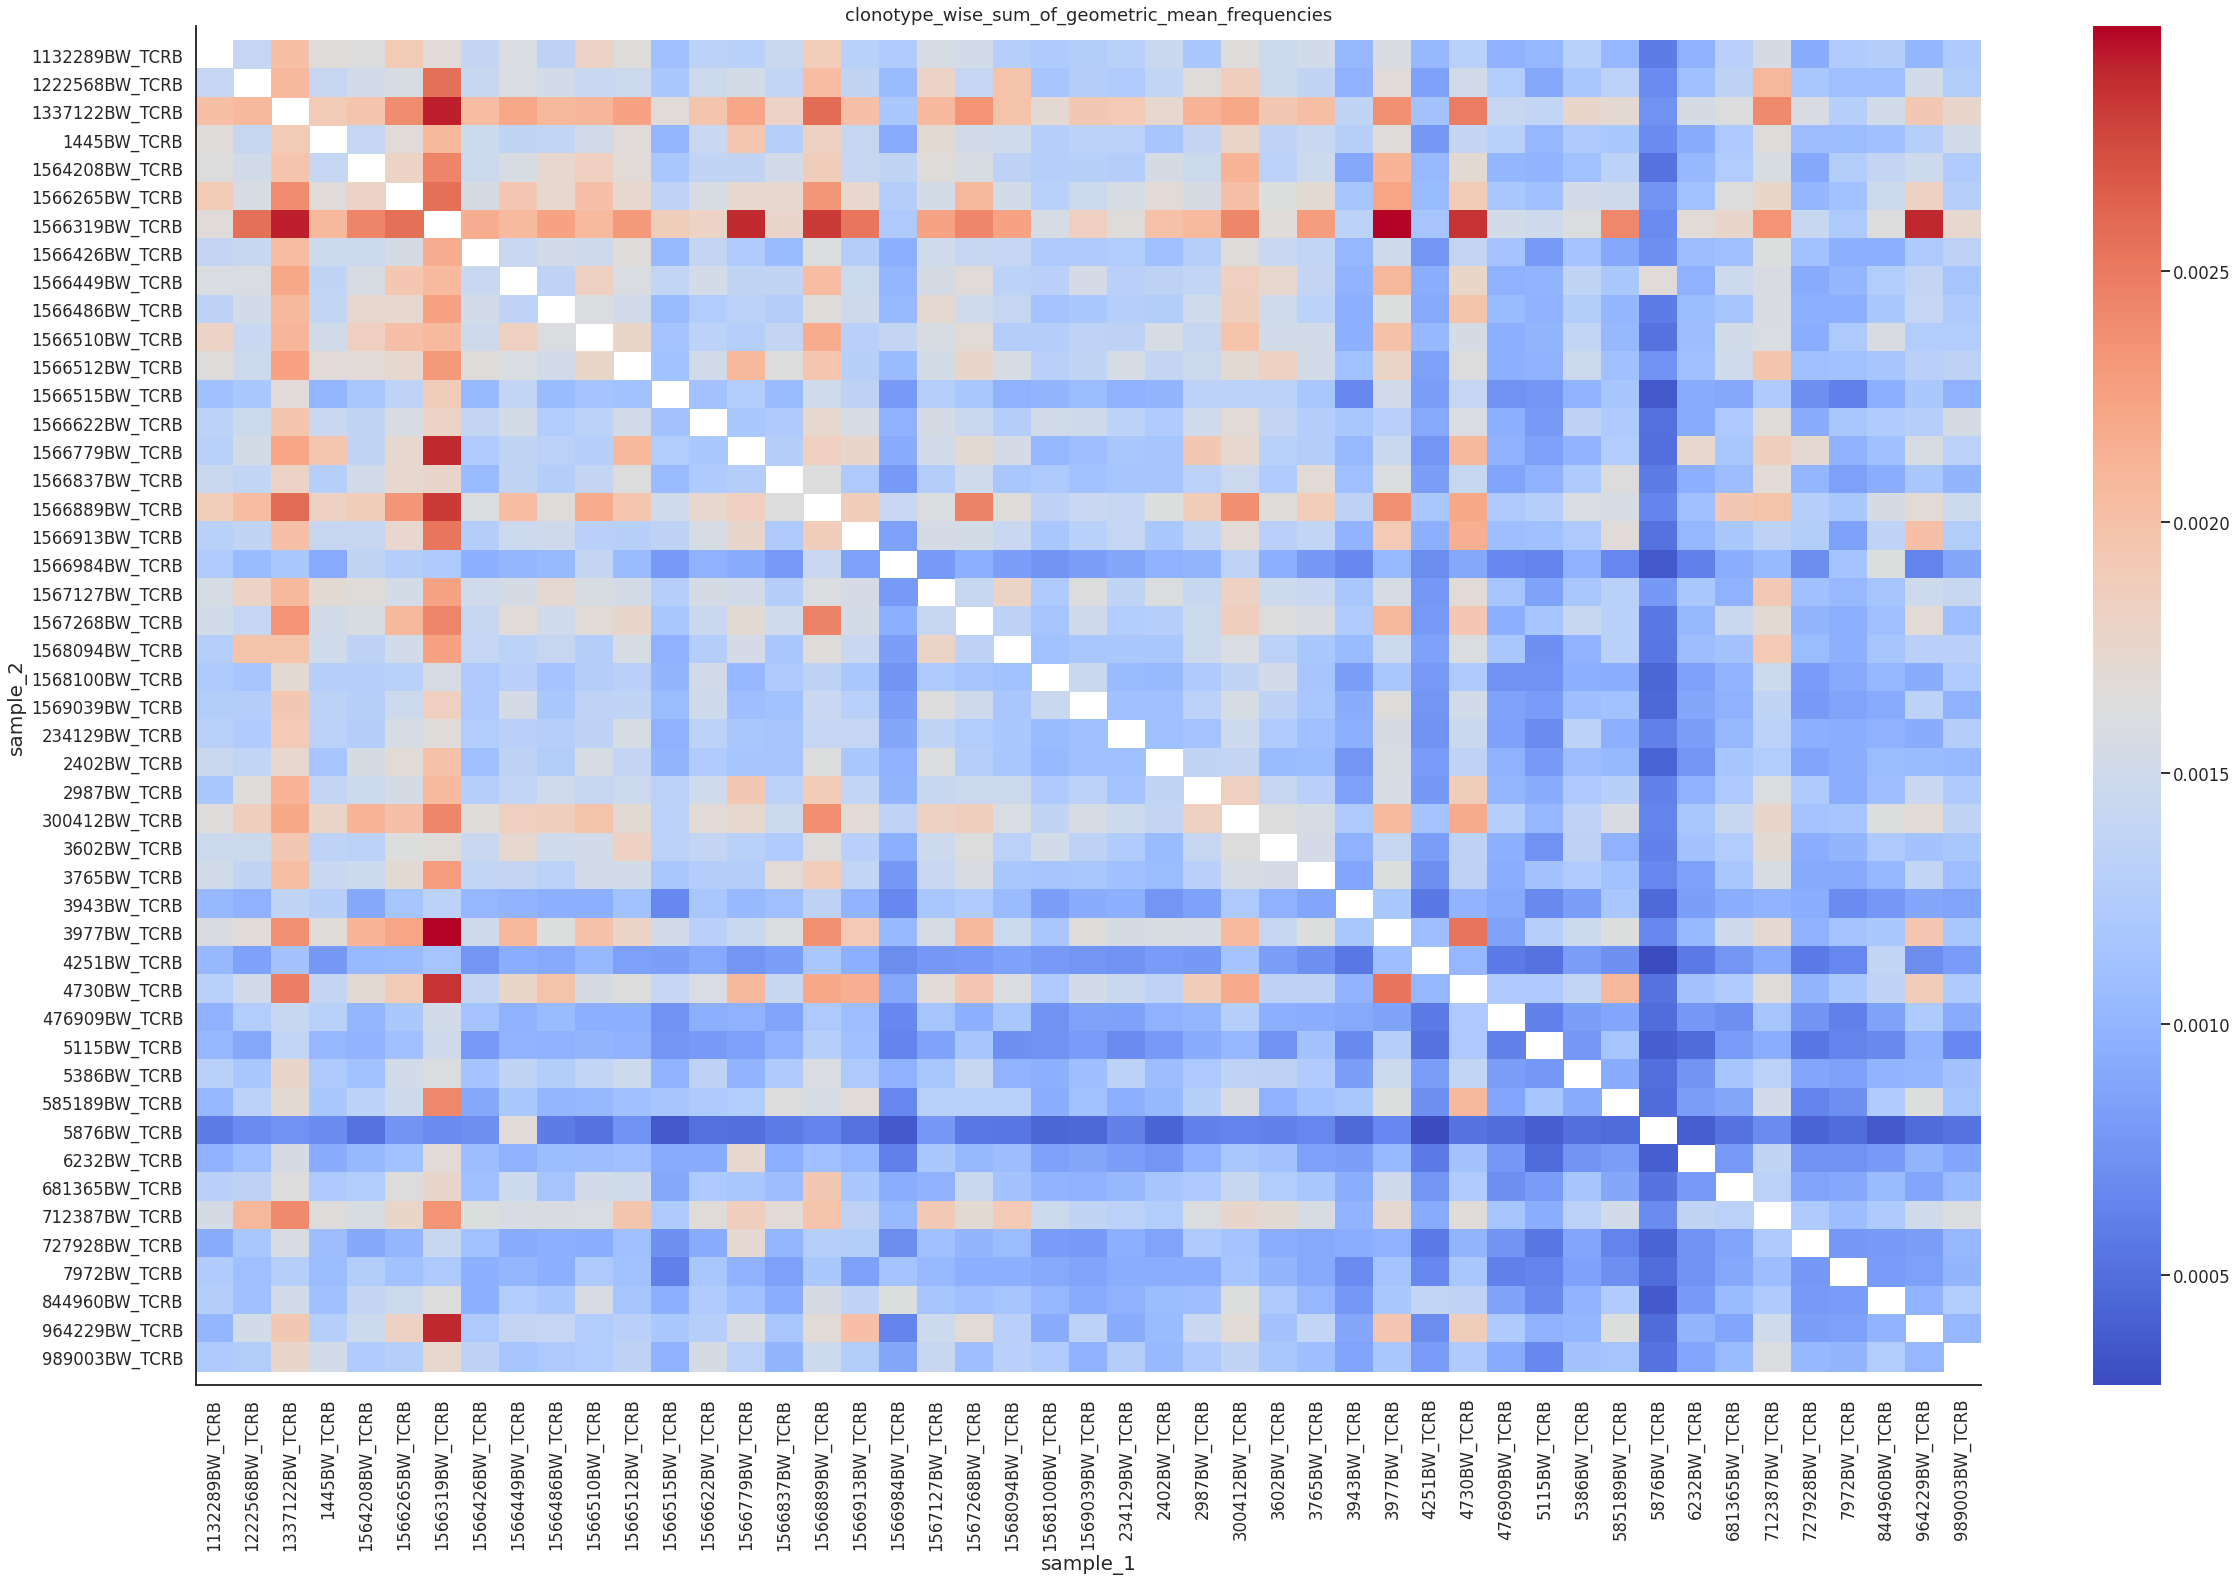

In [27]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_clonotype_wise_sum_of_geometric_mean_frequencies['clonotype_wise_sum_of_geometric_mean_frequencies'] = df_clonotype_wise_sum_of_geometric_mean_frequencies[
    'clonotype_wise_sum_of_geometric_mean_frequencies'].astype(float)
result = df_clonotype_wise_sum_of_geometric_mean_frequencies.pivot(
    index='sample_2', columns='sample_1', values='clonotype_wise_sum_of_geometric_mean_frequencies')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('clonotype_wise_sum_of_geometric_mean_frequencies')


Overlap analysis 10.1 - Jensen-Shannon divergence of variable segment usage distributions (result table)

In [28]:
columns = ['sample_1', 'sample_2', 'jensen_shannon_divergence']
df_jensen_shannon_divergence = pd.DataFrame(columns=columns)


def kl_divergence(p, q):
    return -np.sum(p * np.log2(q / p))


def js_divergence(p, q):
    m = (1 / 2) * (p + q)
    return (1 / 2) * kl_divergence(p, m) + (1 / 2) * kl_divergence(q, m)


for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_sample1_v = df_sample1.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_1': 'sum'})
        df_sample2_v = df_sample2.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_2': 'sum'})

        df_JSD_combine = pd.merge(df_sample1_v, df_sample2_v, on=['v'])

        JSD_sample1 = df_JSD_combine[['sumfreq_1']].to_numpy()
        JSD_sample2 = df_JSD_combine[['sumfreq_2']].to_numpy()

        result = js_divergence(JSD_sample1, JSD_sample2)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jensen_shannon_divergence': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jensen_shannon_divergence': result})

    df_data = pd.DataFrame(data)
    df_jensen_shannon_divergence = pd.concat(
        [df_jensen_shannon_divergence, df_data], copy=False, ignore_index=True)

display(df_jensen_shannon_divergence)


,sample_1,sample_2,jensen_shannon_divergence
0,6232BW_TCRB,5115BW_TCRB,0.147922
1,5115BW_TCRB,6232BW_TCRB,0.147922
2,6232BW_TCRB,989003BW_TCRB,0.031911
3,989003BW_TCRB,6232BW_TCRB,0.031911
4,6232BW_TCRB,7972BW_TCRB,0.040263
...,...,...,...
2157,3602BW_TCRB,1566449BW_TCRB,0.025318
2158,1566449BW_TCRB,1566265BW_TCRB,0.045227
2159,1566265BW_TCRB,1566449BW_TCRB,0.045227
2160,3602BW_TCRB,1566265BW_TCRB,0.019404


Overlap analysis 10.2 - Jensen-Shannon divergence of variable segment usage distributions (heatmap)

Text(0.5, 1.0, 'jensen_shannon_divergence')

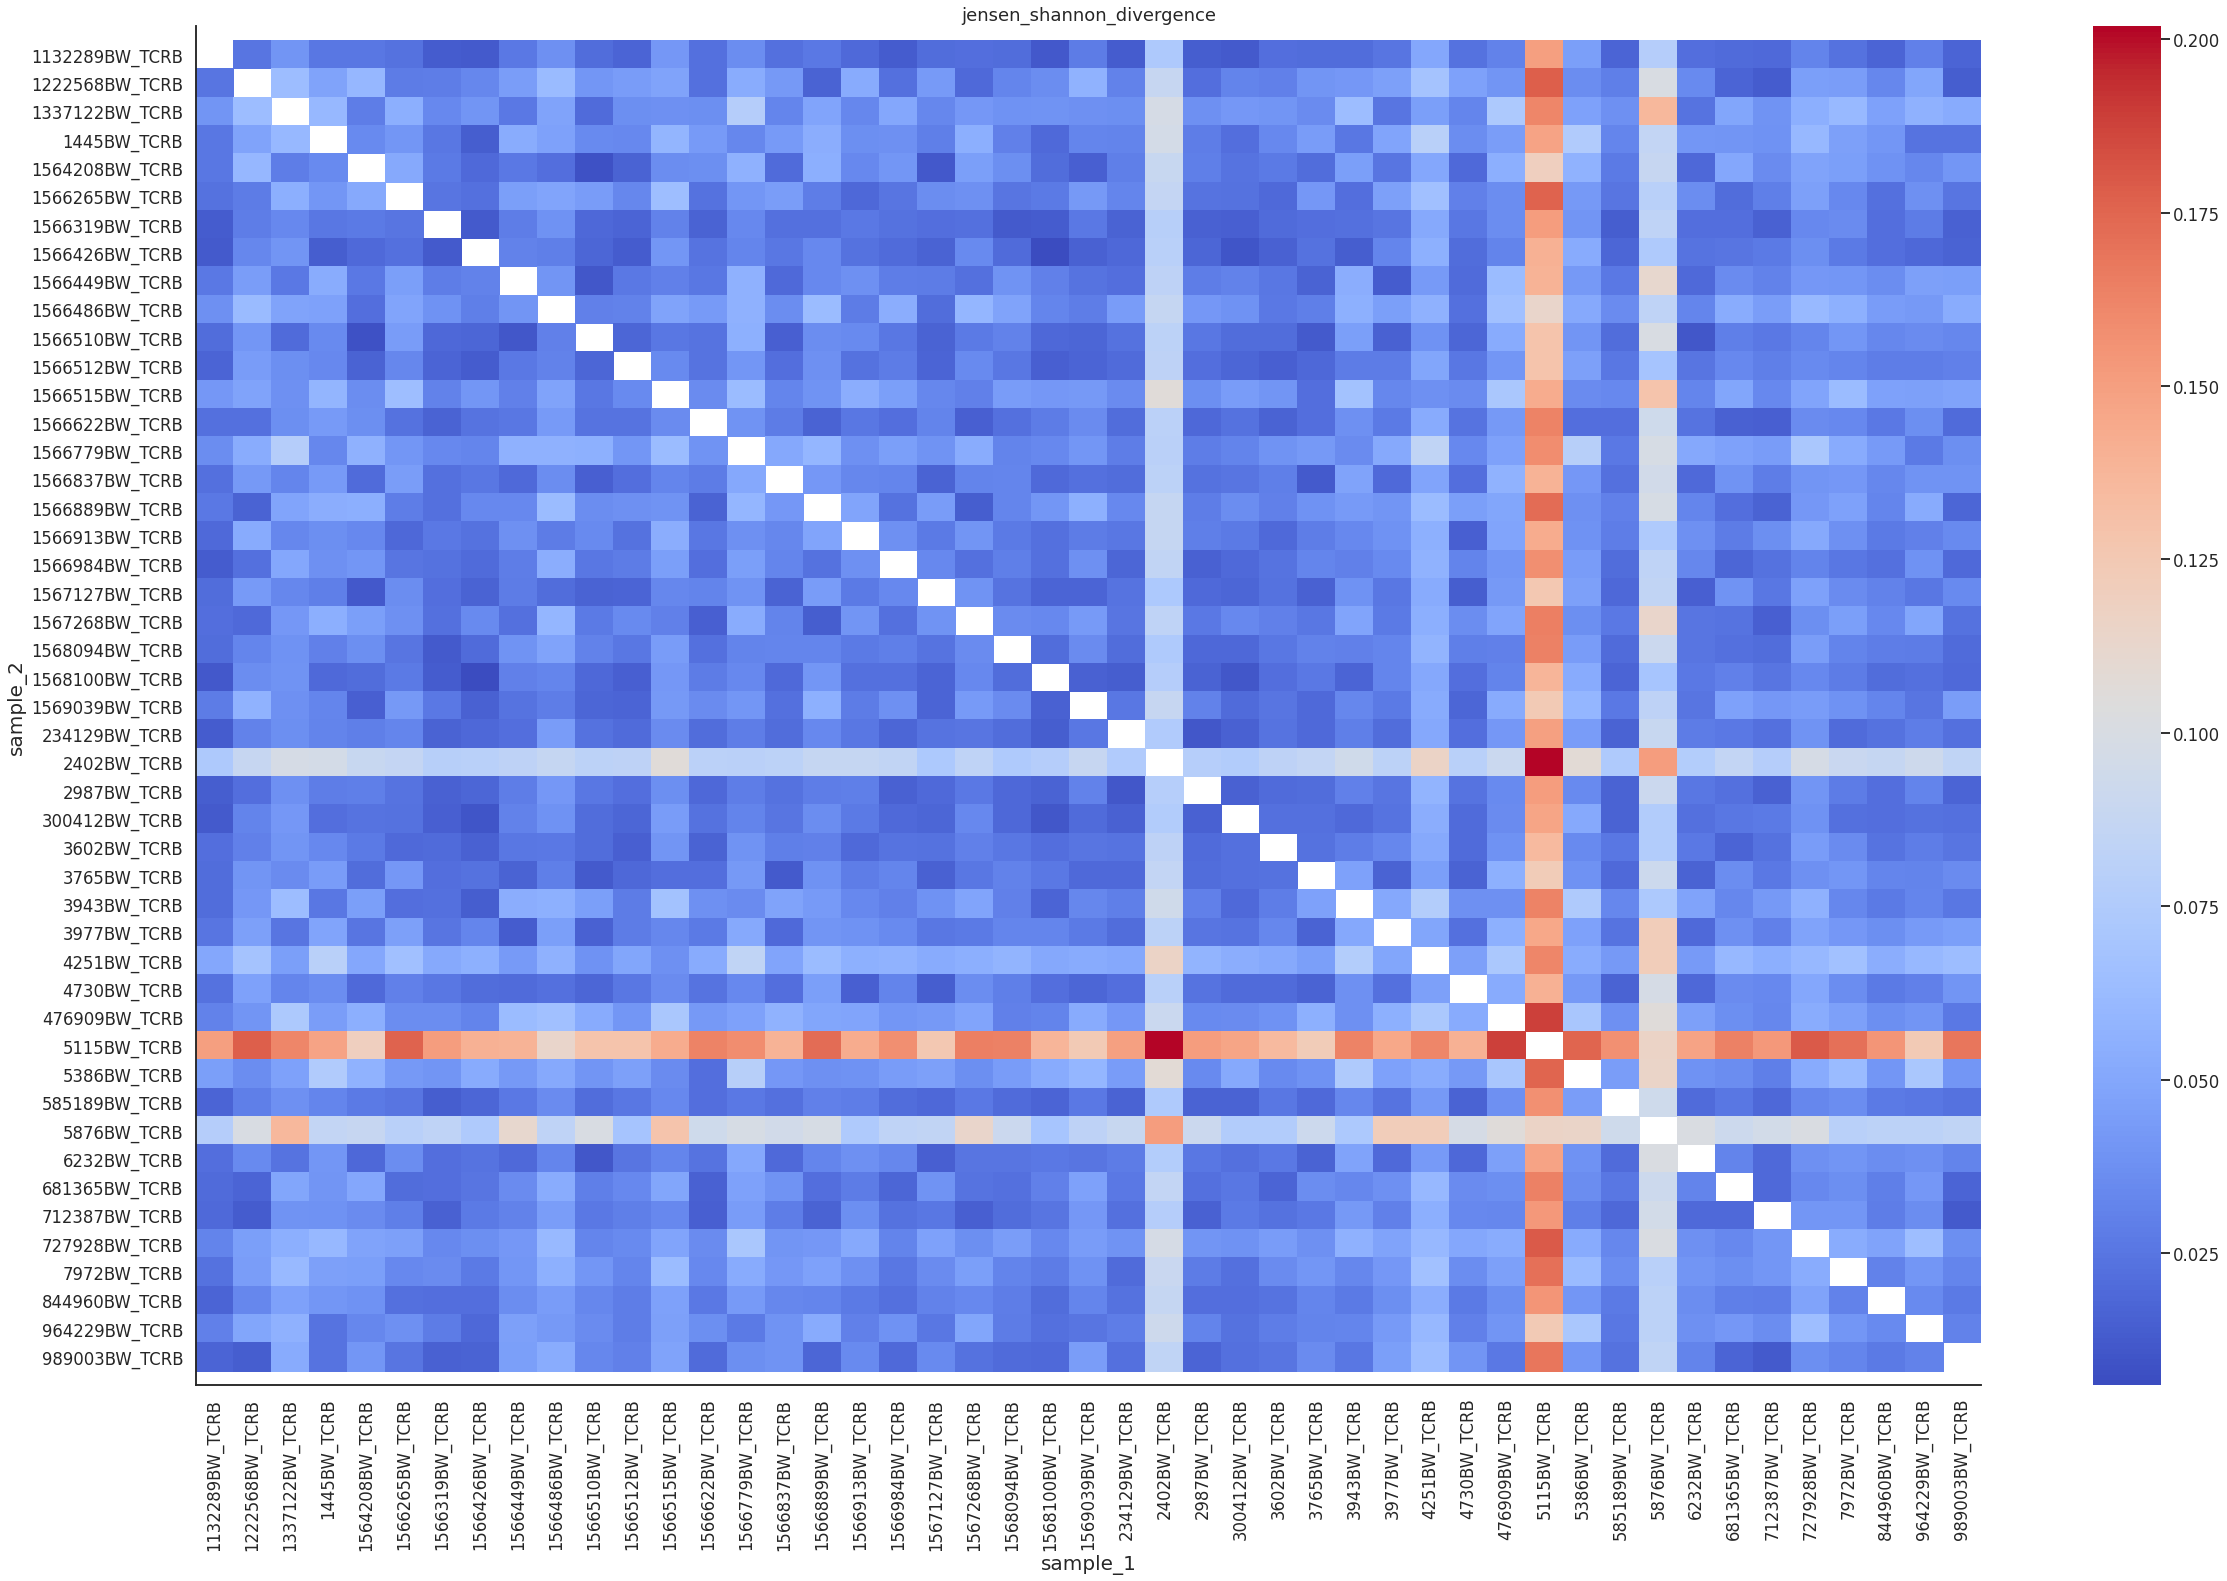

In [29]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_jensen_shannon_divergence['jensen_shannon_divergence'] = df_jensen_shannon_divergence['jensen_shannon_divergence'].astype(
    float)

result = df_jensen_shannon_divergence.pivot(
    index='sample_2', columns='sample_1', values='jensen_shannon_divergence')
    
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('jensen_shannon_divergence')
